# Pre-process ESA Snow CCI data

- Snow Cover Fraction Climate Research Data Package: http://snow-cci.enveo.at/
- summer path: `/mnt/lalandmi/equipes/C2H/ESA_CCI_SNOW`

Check missing values, linear interpolation on time, and spatial aggregation

conda env: `phd_v3`

In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import calendar as cld
import matplotlib.pyplot as plt
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
plot.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
sys.path.insert(1, 'utils') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
# u.check_virtual_memory()

3.8.5 | packaged by conda-forge | (default, Jul 24 2020, 01:25:15) 
[GCC 7.5.0]


In [2]:
# For parallelisation
from dask.distributed import Client
#################
### Fat nodes ###
#################
# oarsub -I -l nodes=2/core=16,walltime=12:00:00 --project regional-climate -t fat
# I put the memory limit higher than the max of memory 1.62 To because all workers does not use the memory in the same time
client = Client(n_workers=16, threads_per_worker=1, memory_limit='300GB')
# client = Client()
client

<Client: 'tcp://127.0.0.1:34725' processes=16 threads=16, memory=4.80 TB>

In [53]:
client.close()

In [3]:
path_snow_CCI = 'ESA_CCI_SNOW/dap.ceda.ac.uk/neodc/esacci/snow/data/scfg'
path_AVHRR = path_snow_CCI+'/AVHRR_MERGED/v2.0'
path_MODIS = path_snow_CCI+'/MODIS/v2.0'

path_out = 'ESA_CCI_SNOW/preprocess/scfg'
path_out_AVHRR = path_out+'/AVHRR_MERGED/v2.0'
path_out_MODIS = path_out+'/MODIS/v2.0'

In [10]:
# for i in range(2001, 2021):
#     print(i)
#     !mkdir {path_out_MODIS}'/daily/'{str(i)}

2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020


MODIS Dimensions:
- lat: 18000
- lon: 36000

On GRICAD 32 cores (6 Go)

In [5]:
print(16/4); print(18000/4); print(36000/4)

4.0
4500.0
9000.0


## Define functions

In [4]:
import xarray as xr
import pandas as pd
from pandas.tseries.offsets import MonthEnd

# Get previous month for interpolation
def get_prev_month_year(month, year):
    '''
    Returns the previous month and corresponding year.

        Parameters:
            month (string): string of 2 characters (e.g., '01')
            year (string): string (e.g., '2000')

        Returns:
            month_prev (string): string of 2 characters (e.g., '12')
            year_prev (string): string (e.g., '1999')
    '''
    if month == '01':
        year_prev = str(int(year) - 1)
        month_prev = '12'
    else:
        year_prev = year
        month_prev = str(int(month) - 1).zfill(2)
        
    return month_prev, year_prev

# Get next month for interpolation
def get_next_month_year(month, year):
    '''
    Returns the next month and corresponding year.

        Parameters:
            month (string): string of 2 characters (e.g., '01')
            year (string): string (e.g., '2000')

        Returns:
            month_prev (string): string of 2 characters (e.g., '02')
            year_prev (string): string (e.g., '2000')
    '''
    if month == '12':
        year_next = str(int(year) + 1)
        month_next = '01'
    else:
        year_next = year
        month_next = str(int(month) + 1).zfill(2)
        
    return month_next, year_next

# Round latitudes and longitudes to avoid errors with concatenation
def round_latlon(ds, latlon_round):
    '''
    Returns Dataset/DataArray with rounded latitudes and longitudes.

        Parameters:
            ds (Dataset/DataArray): xarray Dataset/Dataarray with coords lat/lon
            latlon_round (int): number of decimals

        Returns:
            xarray Dataset/DataArray
    '''
    return ds.assign_coords(lat=ds.lat.round(latlon_round), lon=ds.lon.round(latlon_round))

# Reindex time to get all days for interpolation
def reindex_time(ds, year, month):
    '''
    Returns Dataset/DataArray with all days in the corresponding month. Missing days will be filled with NaNs.

        Parameters:
            ds (Dataset/DataArray): monthly xarray Dataset/DataArray at daily time frequency
            year (string): string (e.g., '2000')
            month (string): string of 2 characters (e.g., '01')

        Returns:
            xarray Dataset/DataArray
    '''
    begin_date = pd.to_datetime(year+'-'+month+'-01')
    end_date = begin_date + MonthEnd(1) # Get the last day of the month
    return ds.reindex(time=pd.date_range(begin_date, end_date, freq='D'))

# Reindex time to get all days for interpolation
def open_files(path, year, month, common_file_string, chunk_lat, chunk_lon, latlon_round, var):
    '''
    Open all daily files for a given month in parallel.
    Format is e.g., path+'/1994/01/19940101'+common_file_string
        
        Need to have Dask client defined before, e.g.:
            from dask.distributed import Client
            client = Client(n_workers=32, threads_per_worker=1, memory_limit='6GB')

        Parameters:
            path (string): root path (e.g., 'ESA_CCI_SNOW/dap.ceda.ac.uk/neodc/esacci/snow/data/scfg/AVHRR_MERGED/v2.0')
            year (string): string (e.g., '2000')
            month (string): string of 2 characters (e.g., '01')
            common_file_string (string): e.g., '-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0.nc'
            chunk_lat (int): chunk over the latitude dimension
            chunk_lon (int): chunk over the longitude dimension
            latlon_round (int): number of decimals
            var (string): variable to open (e.g., 'scfg')

        Returns:
            da (DataArray): xarray DataArray
            attrs (dict): attributes from the original dataset
    '''
    ds = xr.open_mfdataset(path+'/'+year+'/'+month+'/*'+common_file_string, 
                           parallel=True, chunks={'lat': chunk_lat, 'lon': chunk_lon})
    da = ds[var]
    da = round_latlon(da, latlon_round) # round coordinates to avoid errors with concatenation
    da = reindex_time(da, year, month) # to fill missing days with NaNs
    print('Read files '+path+'/'+year+'/'+month+'/*'+common_file_string)
            
    return da, ds.attrs

# Print no file to open
def print_no_file(path, year, month):
    '''
    Print the folder where there is no file.

        Parameters:
            path (string): root path (e.g., 'ESA_CCI_SNOW/dap.ceda.ac.uk/neodc/esacci/snow/data/scfg/AVHRR_MERGED/v2.0')
            year (string): string (e.g., '2000')
            month (string): string of 2 characters (e.g., '01')
    '''
    print('No file to open in: '+path+'/'+year+'/'+month)

# Select last delta_interp days for previous period
def select_last_days(da_prev, year_prev, month_prev, delta_interp):
    '''
    Returns Dataset with the last delta_interp days.

        Parameters:
            da_prev (DataArray): monthly xarray DataArray at daily time frequency
            year_prev (string): string (e.g., '2000')
            month_prev (string): string of 2 characters (e.g., '01')
            delta_interp (int): maximum gap number of days for interpolation

        Returns:
            xarray DataArray
    '''
    end_date = pd.to_datetime(year_prev+'-'+month_prev) + MonthEnd(1) # Get the last day of the month
    begin_date = end_date - pd.DateOffset(days = delta_interp) # Get previous delta_interp days (max window for interpolation)
    return da_prev.sel(time=slice(begin_date, end_date))

# Select next delta_interp days for next period
def select_first_days(da_next, year_next, month_next, delta_interp):
    '''
    Returns Dataset with the last delta_interp days.

        Parameters:
            da_next (DataArray): monthly xarray DataArray at daily time frequency
            year_next (string): string (e.g., '2000')
            month_next (string): string of 2 characters (e.g., '01')
            delta_interp (int): maximum gap number of days for interpolation

        Returns:
            xarray DataArray
    '''
    return da_next.sel(time=slice(year_next+'-'+month_next+'-01', year_next+'-'+month_next+'-'+str(delta_interp).zfill(2)))
     
# Concatenate DataArrays over time
def concat_files(da1, da2, concat_string):
    '''
    Concatenate DataArrays and remove chunks over the time dimension.

        Parameters:
            da1, da2 (DataArray): monthly xarray DataArray at daily time frequency
            concat_string (string): description of concatenation (e.g., '[prev, current]')

        Returns:
            xarray DataArray
    '''
    concat = xr.concat([da1, da2], dim='time').chunk({'time': -1})
    print(' => Concatenate files '+concat_string)
    
    return concat  


## Run interpolation

In [5]:
path = '/bettik/lalandmi/phd/ESA_CCI_SNOW/dap.ceda.ac.uk/neodc/esacci/snow/data/scfg/MODIS/v2.0/2000/12'
for i in range(29, 30):
    print(i)
    xr.open_dataset(path+'/200012'+str(i).zfill(2)+'-ESACCI-L3C_SNOW-SCFG-MODIS_TERRA-fv2.0.nc').load()

29


In [51]:
path = '/bettik/lalandmi/phd/ESA_CCI_SNOW/dap.ceda.ac.uk/neodc/esacci/snow/data/scfg/MODIS/v2.0/2001/01'
for i in range(1, 11):
    print(i)
    xr.open_dataset(path+'/200101'+str(i).zfill(2)+'-ESACCI-L3C_SNOW-SCFG-MODIS_TERRA-fv2.0.nc').load()

1
2
3
4
5
6
7
8
9
10


In [6]:
%%time

import time

chunk_lat = 4500
chunk_lon = 9000
delta_interp = 10 # maximum gap number of days for interpolation
latlon_round = 3 # precision for lat/lon
common_file_string = '-ESACCI-L3C_SNOW-SCFG-MODIS_TERRA-fv2.0.nc'
var = 'scfg'

# for year in [str(y) for y in range(2000, 2021)]:
for year in [str(y) for y in range(2000, 2001)]:
#     for month in [str(m).zfill(2) for m in range(1, 13)]:
    for month in [str(m).zfill(2) for m in range(12, 13)]:
        start_time = time.time() # Check time per loop
        
        # Get previous and next months for interpolation         
        month_prev, year_prev = get_prev_month_year(month, year)
        month_next, year_next = get_next_month_year(month, year)
        print('\n### '+year+'-'+month+' (prev: '+year_prev+'-'+month_prev+' / next: '+year_next+'-'+month_next+')')
        
        ##################
        ### Open files ###
        ##################
        # Test if there are files (ex: 1994-11 to 1995-01 no files for AVHRR)
        try:
            da, attrs = open_files(path_MODIS, year, month, common_file_string, chunk_lat, chunk_lon, latlon_round, var)
        except OSError:
            print_no_file(path_MODIS, year, month)
            continue # If there is no file, go to next iteration
        
        # Prev
        try:
            da_prev, _ = open_files(path_MODIS, year_prev, month_prev, common_file_string, chunk_lat, chunk_lon, latlon_round, var)
            da_prev = select_last_days(da_prev, year_prev, month_prev, delta_interp)
            concat = concat_files(da_prev, da, '[prev, current]')
            
            # Next
            try:
                da_next, _ = open_files(path_MODIS, year_next, month_next, common_file_string, chunk_lat, chunk_lon, latlon_round, var)
                da_next = select_first_days(da_next, year_next, month_next, delta_interp)
                concat = concat_files(concat, da_next, '[concat, next]')
            except OSError:
                print_no_file(path_MODIS, year_next, month_next)

        except OSError:
            print_no_file(path_MODIS, year_prev, month_prev)
        
            # Next
            try:
                da_next, _ = open_files(path_MODIS, year_next, month_next, common_file_string, chunk_lat, chunk_lon, latlon_round, var)
                da_next = select_first_days(da_next, year_next, month_next, delta_interp)
                concat = concat_files(da, da_next, '[current, next]')
            except OSError:
                print_no_file(path_MODIS, year_next, month_next)
                concat = da.chunk({'time': -1})

        ###############################################
        ### Get SCF values and, water and ice masks ###
        ###############################################
        scf = concat.where(concat <= 100)
        water = concat.where(concat == 210)
        ice = concat.where(concat == 215)
        
        ###############################
        ### Linear temporal gapfill ###
        ###############################
        scf_interp = scf.interpolate_na('time', method='linear', max_gap=pd.Timedelta(days=delta_interp))
        print(' => Doing interpolation...')

        # Deal with attributes
        scf_interp.name = var+'_interp'
        del scf_interp.attrs['valid_range']
        del scf_interp.attrs['flag_values']
        del scf_interp.attrs['flag_meanings']
        scf_interp.attrs['ancillary_variables'] = 'coverage, coverage_interp'
        scf_interp.attrs['method'] = var+".interpolate_na('time', method='linear', max_gap=pd.Timedelta(days=10))"

        # Compute time coverage
        coverage = scf.sel(time=year+'-'+month).count('time')
        coverage.name = 'coverage'
        coverage.attrs['long_name'] = 'Time Coverage'
        coverage.attrs['units'] = 'number of days'
        coverage.attrs['ancillary_variables'] = var

        coverage_interp = scf_interp.sel(time=year+'-'+month).count('time')
        coverage_interp.name = 'coverage_interp'
        coverage_interp.attrs['long_name'] = 'Time Coverage'
        coverage_interp.attrs['units'] = 'number of days'
        coverage_interp.attrs['ancillary_variables'] = var+'_interp'

        ice.name = 'mask_ice'
        ice.attrs['long_name'] = 'Permanent_Snow_and_Ice'
        del ice.attrs['units']
        del ice.attrs['standard_name']
        del ice.attrs['valid_range']
        del ice.attrs['actual_range']
        ice.attrs['flag_value'] = 215
        del ice.attrs['flag_values']
        del ice.attrs['flag_meanings']
        del ice.attrs['grid_mapping']
        del ice.attrs['ancillary_variables']

        water.name = 'mask_water'
        water.attrs['long_name'] = 'Water'
        del water.attrs['units']
        del water.attrs['standard_name']
        del water.attrs['valid_range']
        del water.attrs['actual_range']
        water.attrs['flag_value'] = 210
        del water.attrs['flag_values']
        del water.attrs['flag_meanings']
        del water.attrs['grid_mapping']
        del water.attrs['ancillary_variables']

        # Combine in a new dataset
        ds_interp = scf_interp.sel(time=year+'-'+month).to_dataset()
        ds_interp['coverage'] = coverage
        ds_interp['coverage_interp'] = coverage_interp
        ds_interp['mask_ice'] = ice[0]
        ds_interp['mask_water'] = water[0]
        ds_interp.attrs = {**{'processed': 'A linear interpolation on the time dimension is performed in this dataset. ' \
            'A maximum window of 10 days is imposed, if the gap is more than 10 days, the missing values are kept. ' \
            'Before interpolation the time dimension is reindexed in order to cover all days of the month, and fill missing days with NaNs.' \
            'Also the latitudes and longitudes are rounded to 3 digits after de decimal to avoid concatenation errors.' \
            'The temporal coverage of the data before and after interpolation is stored in the variables "coverage" and "coverage_interp". ' \
            'The permanent snow and ice, and water masks are also kept for later processing if needed. The original dataset is described below. ' \
            'Preprocess performed by Mickaël Lalande (https://mickaellalande.github.io/) on May 13, 2022. ' \
            'The same compression level is kept compared to the original dataset (zlib=True, complevel=4).'}, **attrs}

        # Compression
        comp = dict(zlib=True, complevel=4)
        encoding = {var: comp for var in ds_interp.data_vars}
        ds_interp.to_netcdf(path_out_MODIS+'/daily/'+year+'/'+year+month+'-ESACCI-L3C_SNOW-SCFG-MODIS_TERRA-fv2.0_interp.nc', encoding=encoding)
        print('Interpolated file saved to '+path_out_MODIS+'/daily/'+year+'/'+year+month+'-ESACCI-L3C_SNOW-SCFG-MODIS_TERRA-fv2.0_interp.nc')
        print("--- %s seconds ---" % (time.time() - start_time))


### 2000-12 (prev: 2000-11 / next: 2001-01)
Read files ESA_CCI_SNOW/dap.ceda.ac.uk/neodc/esacci/snow/data/scfg/MODIS/v2.0/2000/12/*-ESACCI-L3C_SNOW-SCFG-MODIS_TERRA-fv2.0.nc
Read files ESA_CCI_SNOW/dap.ceda.ac.uk/neodc/esacci/snow/data/scfg/MODIS/v2.0/2000/11/*-ESACCI-L3C_SNOW-SCFG-MODIS_TERRA-fv2.0.nc
 => Concatenate files [prev, current]
Read files ESA_CCI_SNOW/dap.ceda.ac.uk/neodc/esacci/snow/data/scfg/MODIS/v2.0/2001/01/*-ESACCI-L3C_SNOW-SCFG-MODIS_TERRA-fv2.0.nc
 => Concatenate files [concat, next]
 => Doing interpolation...
Interpolated file saved to ESA_CCI_SNOW/preprocess/scfg/MODIS/v2.0/daily/2000/200012-ESACCI-L3C_SNOW-SCFG-MODIS_TERRA-fv2.0_interp.nc
--- 2054.368730068207 seconds ---
CPU times: user 5min 15s, sys: 54.3 s, total: 6min 10s
Wall time: 34min 14s


## Check

In [43]:
path = '/bettik/lalandmi/phd/ESA_CCI_SNOW/dap.ceda.ac.uk/neodc/esacci/snow/data/scfg/MODIS/v2.0/2000/02'
ds = xr.open_dataset(path+'/20000224-ESACCI-L3C_SNOW-SCFG-MODIS_TERRA-fv2.0.nc')
ds

<xarray.Dataset>
Dimensions:      (lat: 18000, lon: 36000, nv: 2, time: 1)
Coordinates:
  * time         (time) datetime64[ns] 2000-02-24
  * lat          (lat) float64 -90.0 -89.98 -89.97 -89.97 ... 89.98 89.98 90.0
  * lon          (lon) float64 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
Dimensions without coordinates: nv
Data variables:
    lat_bnds     (lat, nv) float64 ...
    lon_bnds     (lon, nv) float64 ...
    scfg         (time, lat, lon) float32 ...
    scfg_unc     (time, lat, lon) float32 ...
    spatial_ref  int32 ...
Attributes:
    title:                      ESA CCI snow on ground product level L3C dail...
    institution:                ENVEO IT GmbH
    source:                     TERRA MODIS, Collection 6.1: calibrated radia...
    history:                    2021-12-03: ESA snow_cci processing line SCFG...
    references:                 http://snow-cci.enveo.at/
    tracking_id:                071766fd-d627-4051-81c7-4c54e4f4b8f8
    Conventions:                CF-1.9
    product_version:            2.0
    format_version:             CCI Data Standards v2.3, 2021
    summary:                    The SCF product provides daily information on...
    keywords:                   snow cover, MODIS, TERRA
    id:                         20000224-ESACCI-L3C_SNOW-SCFG-MODIS_TERRA-fv2...
    naming_authority:           at.enveo
    keywords_vocabulary:        NASA Global Change Master Directory (GCMD) Sc...
    cdm_data_type:              Swath
    comment:                    The following auxiliary data sets are used fo...
    date_created:               2021-11-18 00:22:17Z
    creator_name:               ENVEO IT GmbH
    creator_url:                http://www.enveo.at/
    creator_email:              snowcci@enveo.at
    project:                    Climate Change Initiative - European Space Ag...
    geospatial_lat_min:         -90
    geospatial_lat_max:         90
    geospatial_lon_min:         -180
    geospatial_lon_max:         180
    geospatial_vertical_min:    0
    geospatial_vertical_max:    0
    geospatial_lon_resolution:  0.01
    geospatial_lat_resolution:  0.01
    geospatial_lat_units:       degrees_north
    geospatial_lon_units:       degrees_east
    time_coverage_start:        20000224T000000Z
    time_coverage_end:          20000224T235959Z
    time_coverage_duration:     P1D
    time_coverage_resolution:   P1D
    standard_name_vocabulary:   CF Standard Name Table v78
    license:                    ESA CCI Data Policy: free and open access
    platform:                   TERRA
    sensor:                     MODIS
    spatial_resolution:         0.01 degree
    key_variables:              scfg
    doi:                        10.5285/8847a05eeda646a29da58b42bdf2a87c

In [45]:
path = '/bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/scfg/MODIS/v2.0/daily/2000'
ds = xr.open_dataset(path+'/200004-ESACCI-L3C_SNOW-SCFG-MODIS_TERRA-fv2.0_interp.nc')
ds

<xarray.Dataset>
Dimensions:          (lat: 18000, lon: 36000, time: 30)
Coordinates:
  * lat              (lat) float64 -90.0 -89.98 -89.97 ... 89.97 89.98 90.0
  * lon              (lon) float64 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * time             (time) datetime64[ns] 2000-04-01 2000-04-02 ... 2000-04-30
Data variables:
    scfg_interp      (time, lat, lon) float64 ...
    coverage         (lat, lon) int64 ...
    coverage_interp  (lat, lon) int64 ...
    mask_ice         (lat, lon) float32 ...
    mask_water       (lat, lon) float32 ...
Attributes:
    processed:                  A linear interpolation on the time dimension ...
    title:                      ESA CCI snow on ground product level L3C dail...
    institution:                ENVEO IT GmbH
    source:                     TERRA MODIS, Collection 6.1: calibrated radia...
    history:                    2021-12-03: ESA snow_cci processing line SCFG...
    references:                 http://snow-cci.enveo.at/
    tracking_id:                9b16bba0-7a12-4295-ade2-f0d9746de0c2
    Conventions:                CF-1.9
    product_version:            2.0
    format_version:             CCI Data Standards v2.3, 2021
    summary:                    The SCF product provides daily information on...
    keywords:                   snow cover, MODIS, TERRA
    id:                         20000401-ESACCI-L3C_SNOW-SCFG-MODIS_TERRA-fv2...
    naming_authority:           at.enveo
    keywords_vocabulary:        NASA Global Change Master Directory (GCMD) Sc...
    cdm_data_type:              Swath
    comment:                    The following auxiliary data sets are used fo...
    date_created:               2021-11-08 22:15:43Z
    creator_name:               ENVEO IT GmbH
    creator_url:                http://www.enveo.at/
    creator_email:              snowcci@enveo.at
    project:                    Climate Change Initiative - European Space Ag...
    geospatial_lat_min:         -90
    geospatial_lat_max:         90
    geospatial_lon_min:         -180
    geospatial_lon_max:         180
    geospatial_vertical_min:    0
    geospatial_vertical_max:    0
    geospatial_lon_resolution:  0.01
    geospatial_lat_resolution:  0.01
    geospatial_lat_units:       degrees_north
    geospatial_lon_units:       degrees_east
    time_coverage_start:        20000401T000000Z
    time_coverage_end:          20000401T235959Z
    time_coverage_duration:     P1D
    time_coverage_resolution:   P1D
    standard_name_vocabulary:   CF Standard Name Table v78
    license:                    ESA CCI Data Policy: free and open access
    platform:                   TERRA
    sensor:                     MODIS
    spatial_resolution:         0.01 degree
    key_variables:              scfg
    doi:                        10.5285/8847a05eeda646a29da58b42bdf2a87c

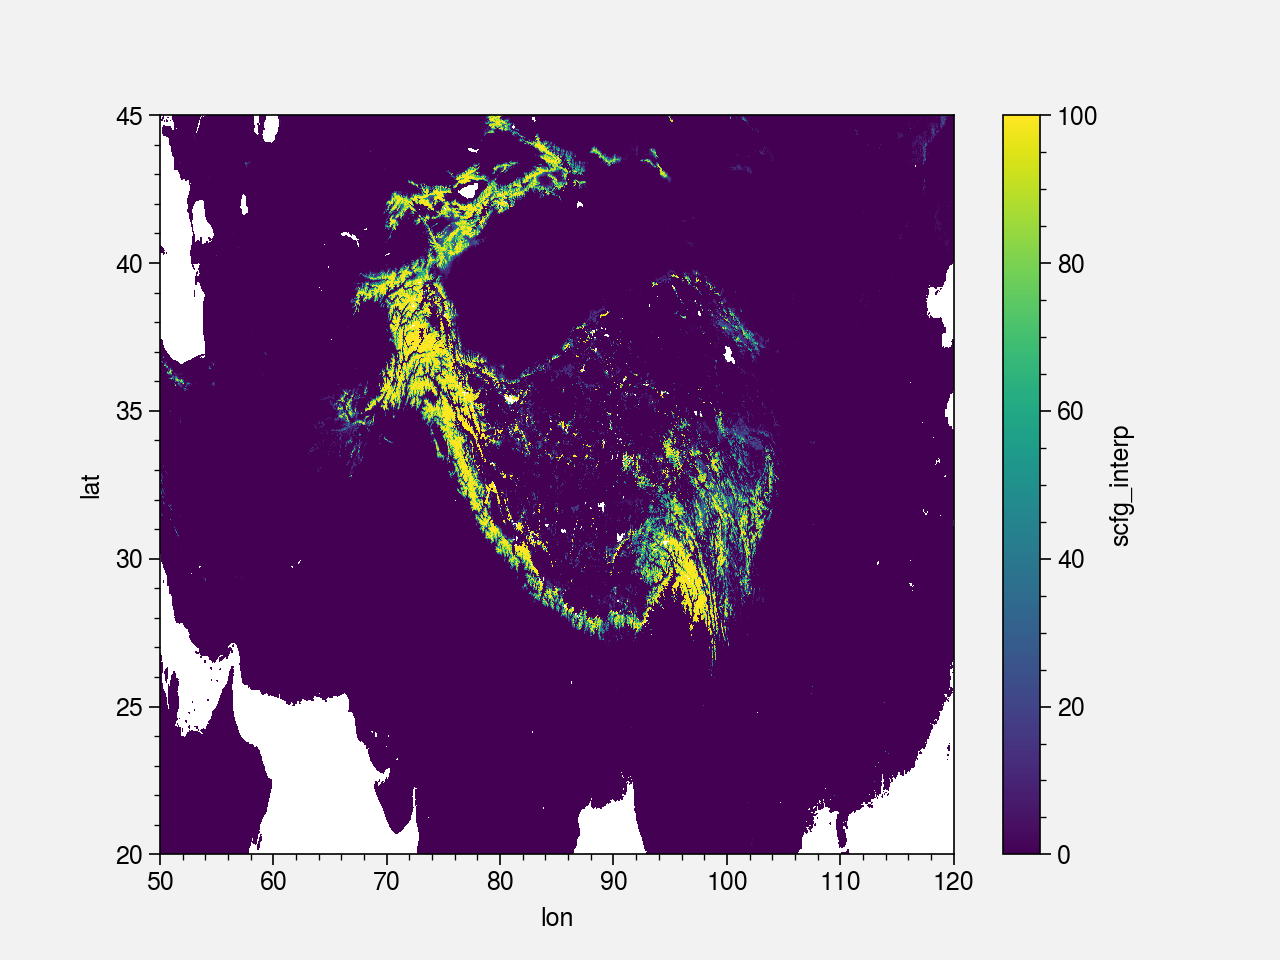

In [42]:
ds.scfg_interp.sel(lat=slice(20, 45), lon=slice(50, 120)).mean('time').plot()

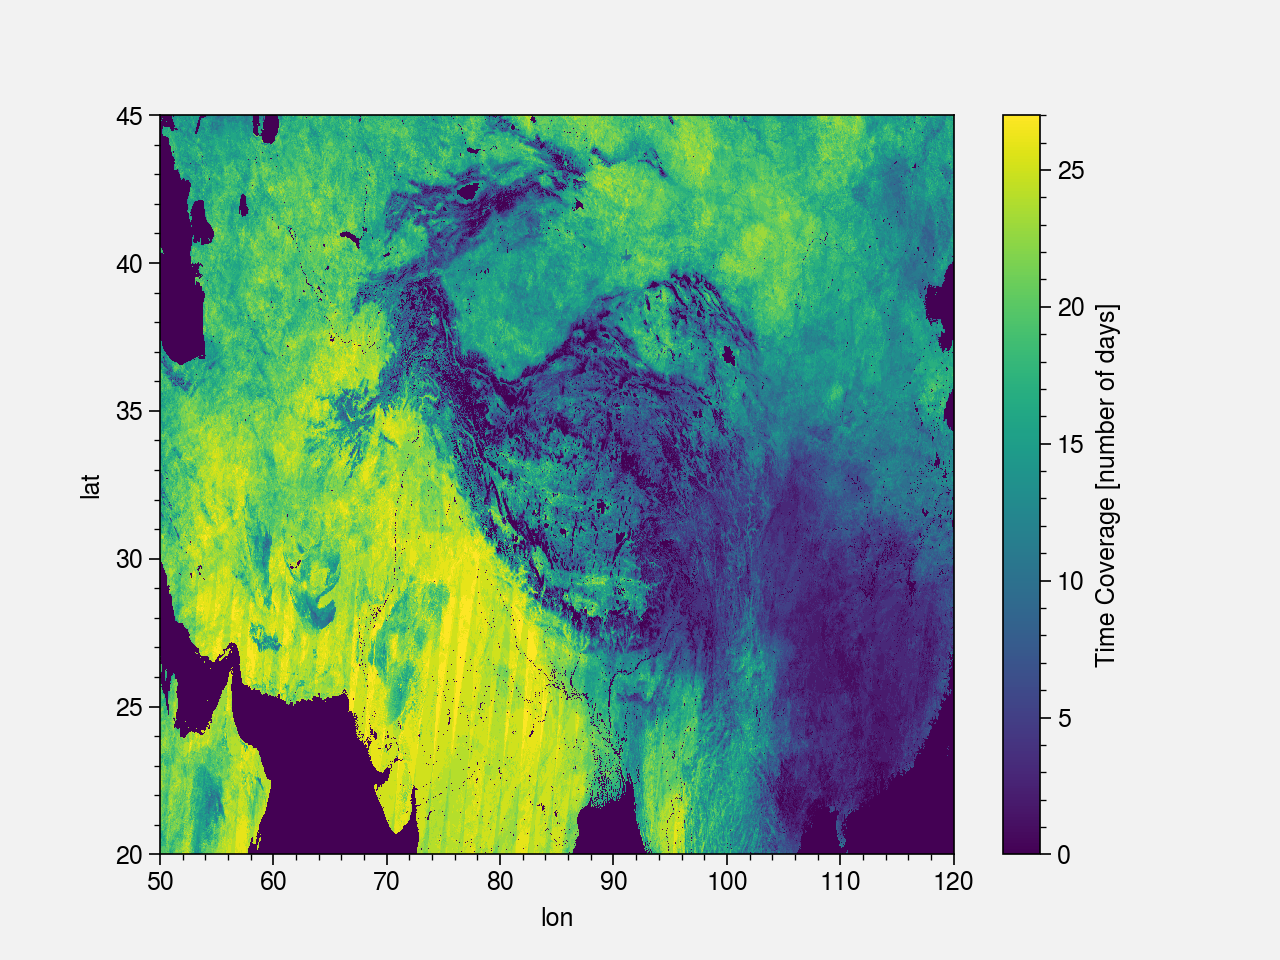

In [39]:
ds.coverage.sel(lat=slice(20, 45), lon=slice(50, 120)).plot()

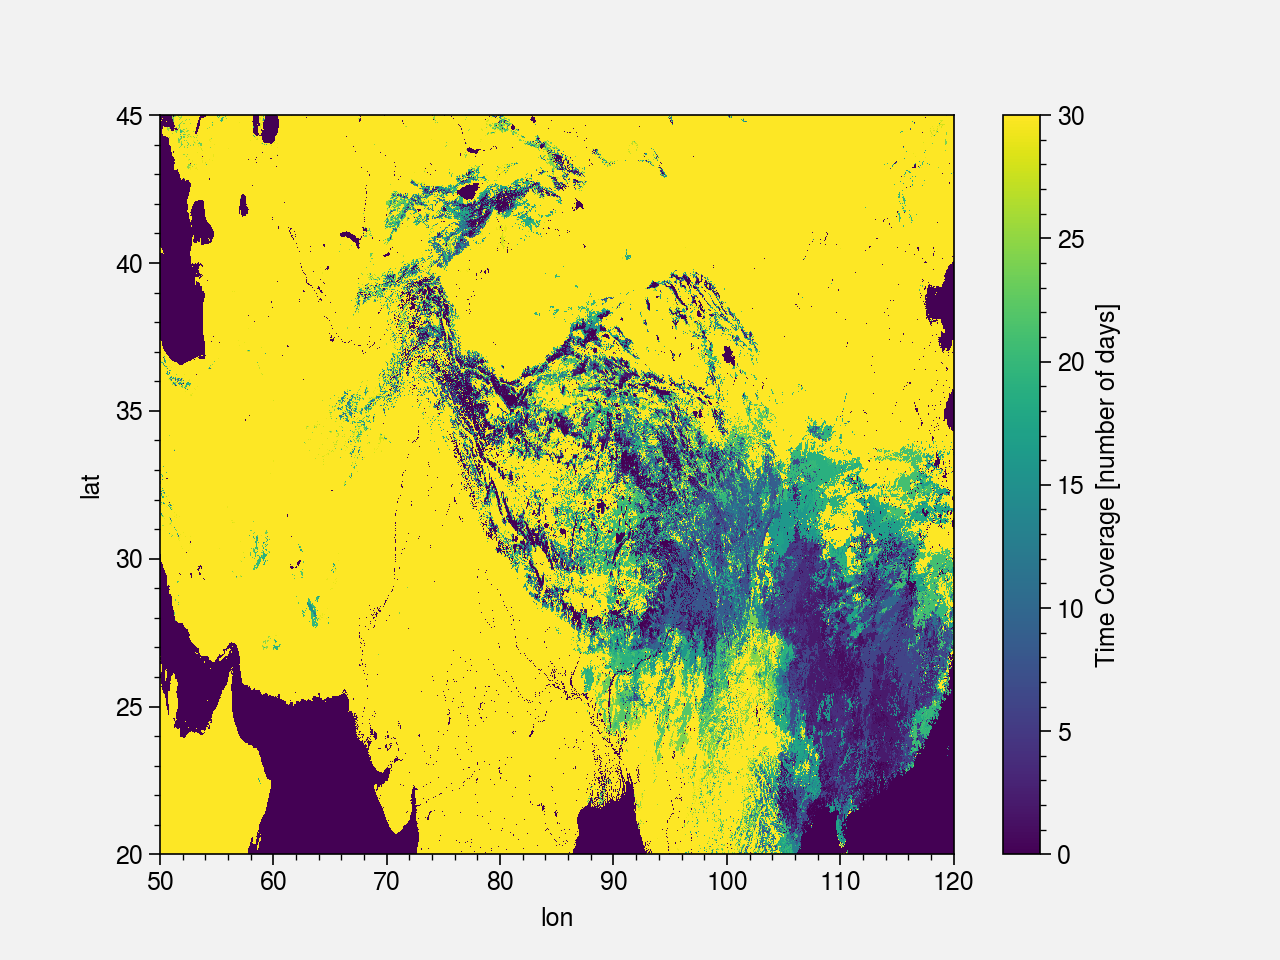

In [40]:
ds.coverage_interp.sel(lat=slice(20, 45), lon=slice(50, 120)).plot()

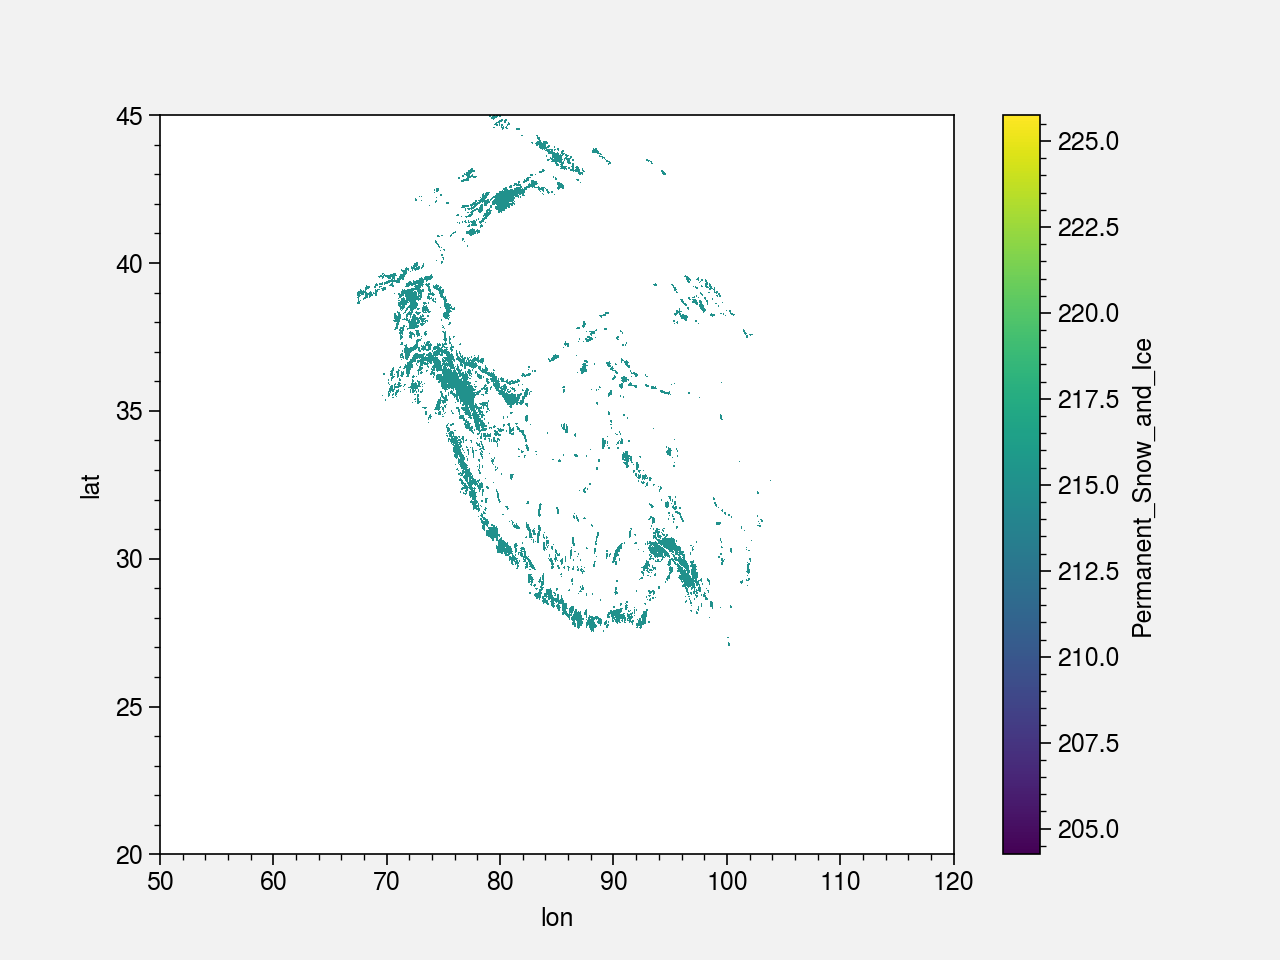

In [36]:
ds.mask_ice.sel(lat=slice(20, 45), lon=slice(50, 120)).plot()

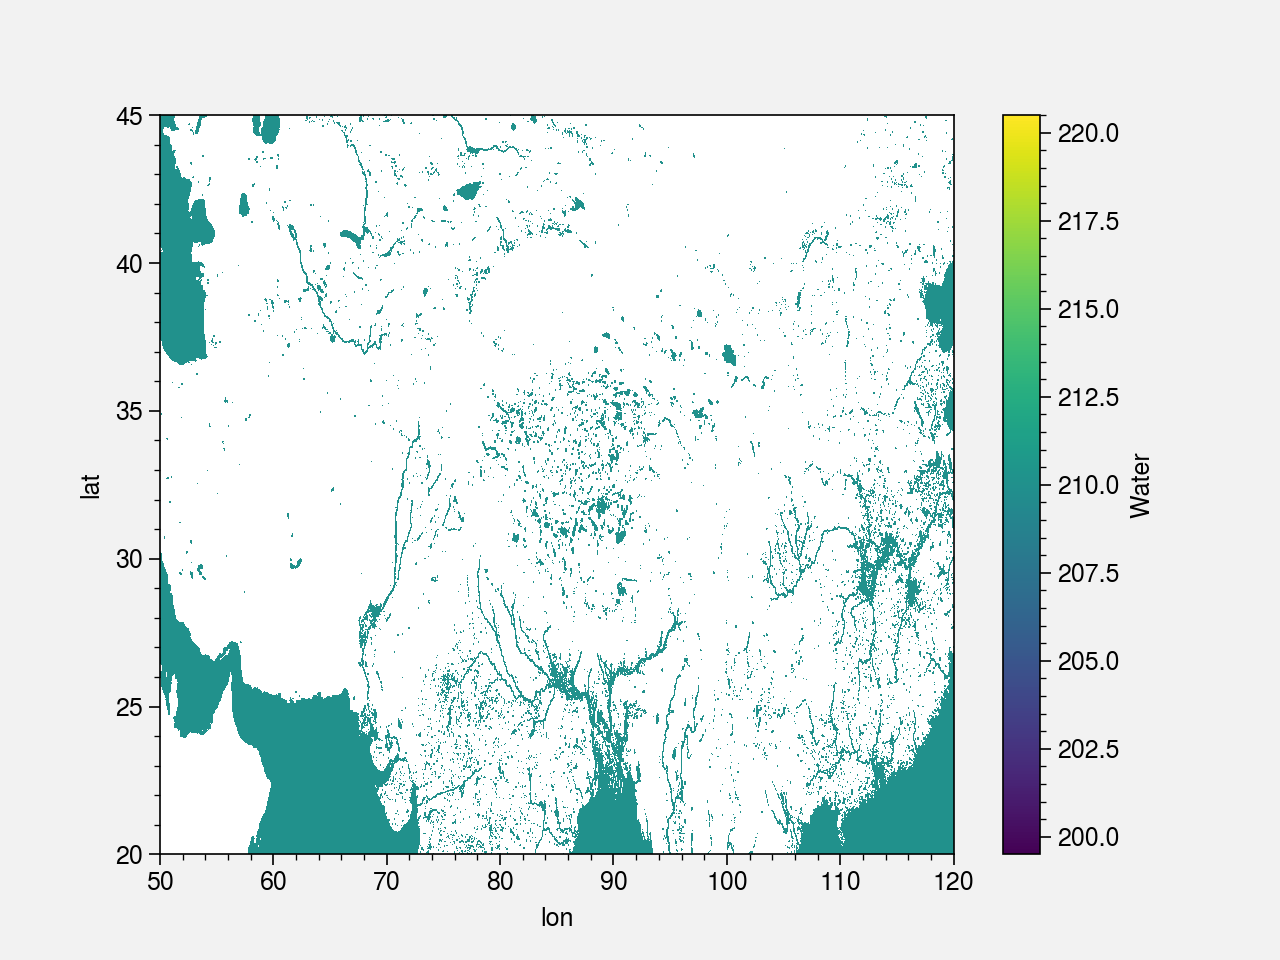

In [37]:
ds.mask_water.sel(lat=slice(20, 45), lon=slice(50, 120)).plot()

# Make monthly mean

In [5]:
root_path_in = '/bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/scfg/MODIS/v2.0/daily'
root_path_out = '/bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/scfg/MODIS/v2.0/monthly'

MODIS Dimensions:
- lat: 18000
- lon: 36000

On GRICAD 32 cores (6 Go)

In [6]:
4500/4

1125.0

In [6]:
%%time

import time

# Increase a bit the chunks as I leave the chunk on time (monthly chunk 31 days)
# chunk_lat = 4500
# chunk_lon = 9000

chunk_lat = 4500
chunk_lon = 9000

# for year in [str(y) for y in range(2000, 2021)]:
for year in [str(y) for y in range(2000, 2001)]:
    start_time = time.time() # Check time per loop
    
    print('\n### '+year)
    
    ds = xr.open_mfdataset(root_path_in+'/'+year+'/*-ESACCI-L3C_SNOW-SCFG-MODIS_TERRA-fv2.0_interp.nc', parallel=True, chunks={'lat': chunk_lat, 'lon': chunk_lon})
    print('Read files '+root_path_in+'/'+year+'/*-ESACCI-L3C_SNOW-SCFG-MODIS_TERRA-fv2.0_interp.nc')
    
#     ds_month = ds.chunk({'time': -1}).resample(time='1M').mean() # too heavy
    ds_month = ds.resample(time='1M').mean()
    print(' => Perform monthly resample average...')
    
    ds_month.attrs = ds.attrs
    
     # Compression
    comp = dict(zlib=True, complevel=4)
    encoding = {var: comp for var in ds_month.data_vars}
    ds_month.to_netcdf(root_path_out+'/'+year+'-monthly-ESACCI-L3C_SNOW-SCFG-MODIS_TERRA-fv2.0_interp.nc', encoding=encoding)
    print('Monthly file saved to '+root_path_out+'/'+year+'-monthly-ESACCI-L3C_SNOW-SCFG-MODIS_TERRA-fv2.0_interp.nc')
    print("--- %s seconds ---" % (time.time() - start_time))


### 2000
Read files /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/scfg/MODIS/v2.0/daily/2000/*-ESACCI-L3C_SNOW-SCFG-MODIS_TERRA-fv2.0_interp.nc
 => Perform monthly resample average...


/bettik/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


Monthly file saved to /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/scfg/MODIS/v2.0/monthly/2000-monthly-ESACCI-L3C_SNOW-SCFG-MODIS_TERRA-fv2.0_interp.nc
--- 1754.0583624839783 seconds ---
CPU times: user 4min 51s, sys: 38.8 s, total: 5min 29s
Wall time: 29min 14s


## Check

In [7]:
ds = xr.open_mfdataset(root_path_out+'/*.nc', parallel=True)
ds

<xarray.Dataset>
Dimensions:          (lat: 18000, lon: 36000, time: 11)
Coordinates:
  * time             (time) datetime64[ns] 2000-02-29 2000-03-31 ... 2000-12-31
  * lat              (lat) float64 -90.0 -89.98 -89.97 ... 89.97 89.98 90.0
  * lon              (lon) float64 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
Data variables:
    scfg_interp      (time, lat, lon) float64 dask.array<chunksize=(11, 18000, 36000), meta=np.ndarray>
    coverage         (time, lat, lon) float64 dask.array<chunksize=(11, 18000, 36000), meta=np.ndarray>
    coverage_interp  (time, lat, lon) float64 dask.array<chunksize=(11, 18000, 36000), meta=np.ndarray>
    mask_ice         (time, lat, lon) float32 dask.array<chunksize=(11, 18000, 36000), meta=np.ndarray>
    mask_water       (time, lat, lon) float32 dask.array<chunksize=(11, 18000, 36000), meta=np.ndarray>
Attributes:
    processed:                  A linear interpolation on the time dimension ...
    title:                      ESA CCI snow on ground product level L3C dail...
    institution:                ENVEO IT GmbH
    source:                     TERRA MODIS, Collection 6.1: calibrated radia...
    history:                    2021-12-03: ESA snow_cci processing line SCFG...
    references:                 http://snow-cci.enveo.at/
    tracking_id:                071766fd-d627-4051-81c7-4c54e4f4b8f8
    Conventions:                CF-1.9
    product_version:            2.0
    format_version:             CCI Data Standards v2.3, 2021
    summary:                    The SCF product provides daily information on...
    keywords:                   snow cover, MODIS, TERRA
    id:                         20000224-ESACCI-L3C_SNOW-SCFG-MODIS_TERRA-fv2...
    naming_authority:           at.enveo
    keywords_vocabulary:        NASA Global Change Master Directory (GCMD) Sc...
    cdm_data_type:              Swath
    comment:                    The following auxiliary data sets are used fo...
    date_created:               2021-11-18 00:22:17Z
    creator_name:               ENVEO IT GmbH
    creator_url:                http://www.enveo.at/
    creator_email:              snowcci@enveo.at
    project:                    Climate Change Initiative - European Space Ag...
    geospatial_lat_min:         -90
    geospatial_lat_max:         90
    geospatial_lon_min:         -180
    geospatial_lon_max:         180
    geospatial_vertical_min:    0
    geospatial_vertical_max:    0
    geospatial_lon_resolution:  0.01
    geospatial_lat_resolution:  0.01
    geospatial_lat_units:       degrees_north
    geospatial_lon_units:       degrees_east
    time_coverage_start:        20000224T000000Z
    time_coverage_end:          20000224T235959Z
    time_coverage_duration:     P1D
    time_coverage_resolution:   P1D
    standard_name_vocabulary:   CF Standard Name Table v78
    license:                    ESA CCI Data Policy: free and open access
    platform:                   TERRA
    sensor:                     MODIS
    spatial_resolution:         0.01 degree
    key_variables:              scfg
    doi:                        10.5285/8847a05eeda646a29da58b42bdf2a87c

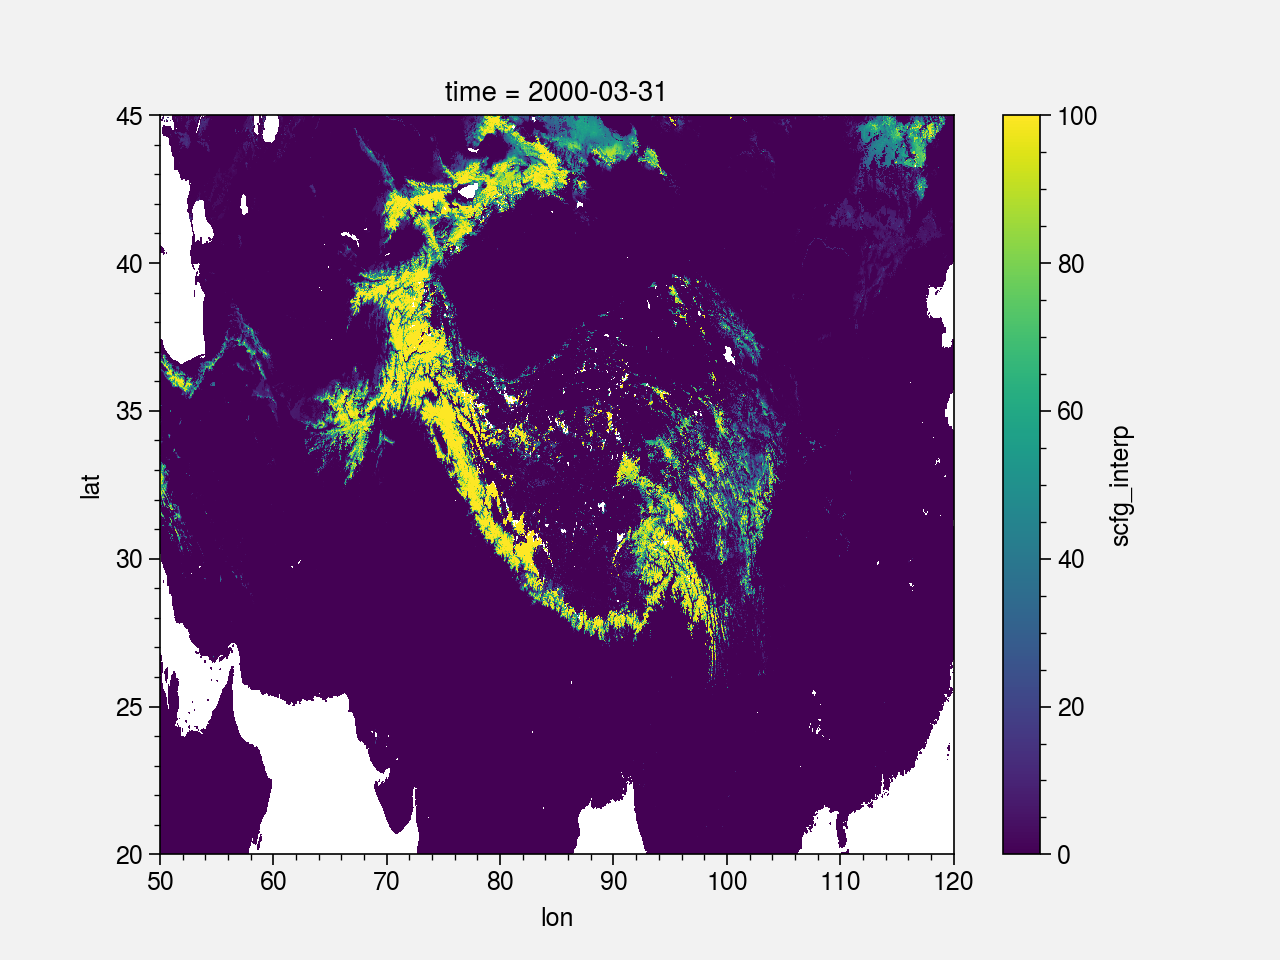

In [11]:
ds.scfg_interp.sel(lat=slice(20, 45), lon=slice(50, 120))[1].plot()

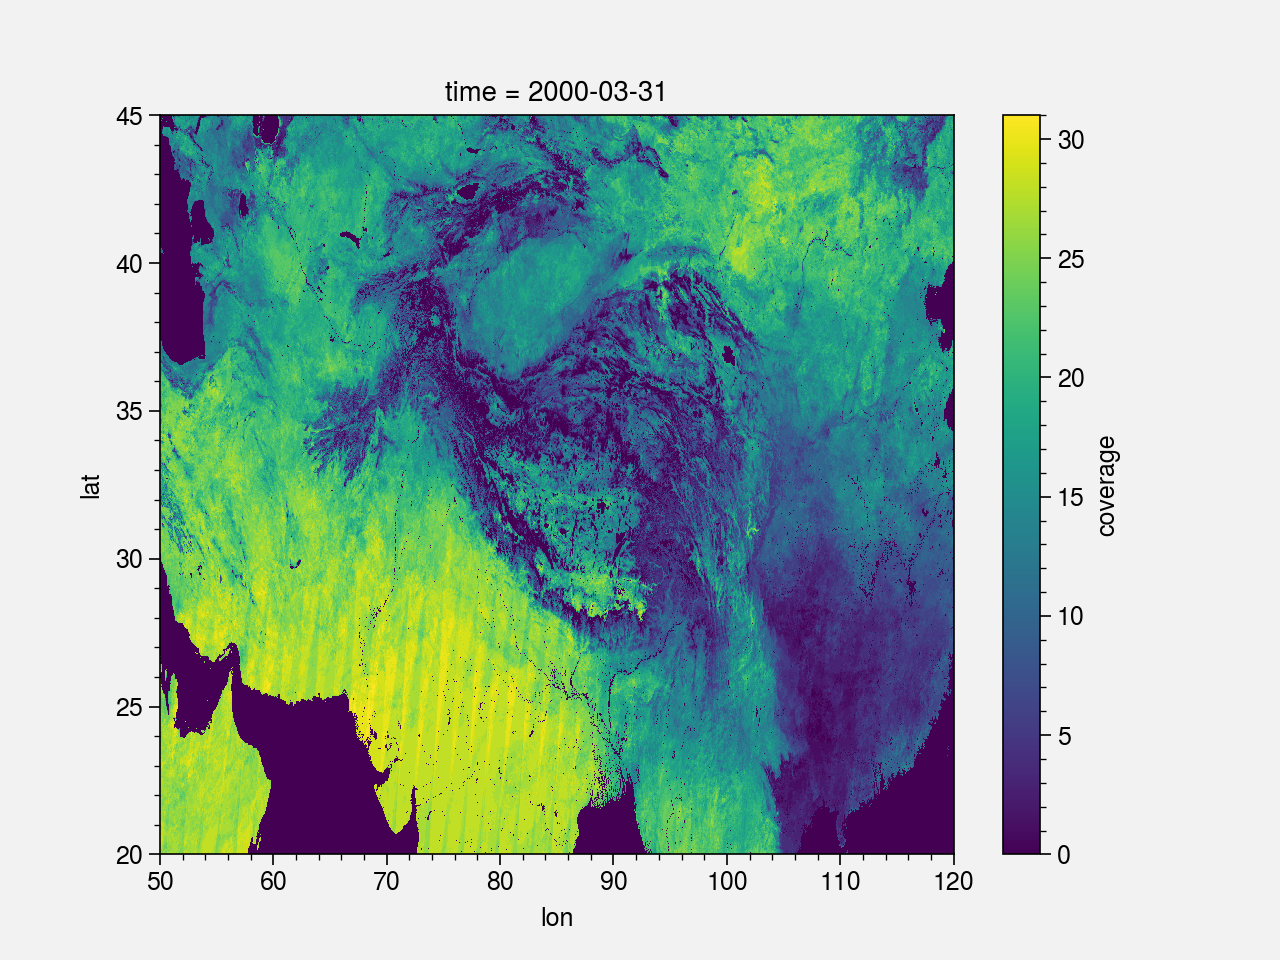

In [12]:
ds.coverage.sel(lat=slice(20, 45), lon=slice(50, 120))[1].plot()

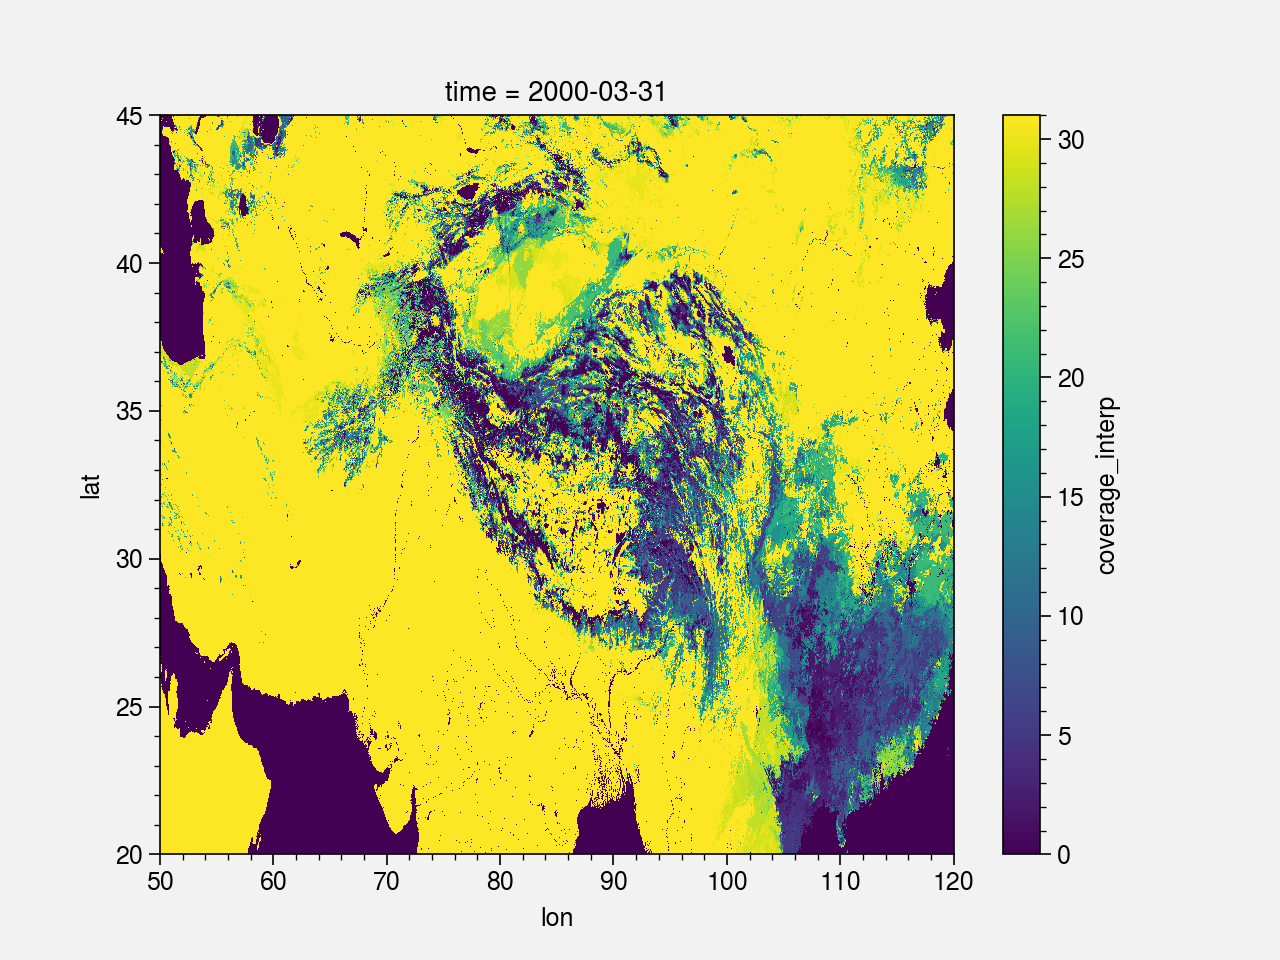

In [13]:
ds.coverage_interp.sel(lat=slice(20, 45), lon=slice(50, 120))[1].plot()

# Make spatial average

In [41]:
year = '2000'
ds = xr.open_dataset(root_path_out+'/'+year+'-monthly-ESACCI-L3C_SNOW-SCFG-MODIS_TERRA-fv2.0_interp.nc', chunks={'time': 1})

In [19]:
ds

<xarray.Dataset>
Dimensions:          (lat: 18000, lon: 36000, time: 11)
Coordinates:
  * time             (time) datetime64[ns] 2000-02-29 2000-03-31 ... 2000-12-31
  * lat              (lat) float64 -90.0 -89.98 -89.97 ... 89.97 89.98 90.0
  * lon              (lon) float64 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
Data variables:
    scfg_interp      (time, lat, lon) float64 dask.array<chunksize=(1, 18000, 36000), meta=np.ndarray>
    coverage         (time, lat, lon) float64 dask.array<chunksize=(1, 18000, 36000), meta=np.ndarray>
    coverage_interp  (time, lat, lon) float64 dask.array<chunksize=(1, 18000, 36000), meta=np.ndarray>
    mask_ice         (time, lat, lon) float32 dask.array<chunksize=(1, 18000, 36000), meta=np.ndarray>
    mask_water       (time, lat, lon) float32 dask.array<chunksize=(1, 18000, 36000), meta=np.ndarray>
Attributes:
    processed:                  A linear interpolation on the time dimension ...
    title:                      ESA CCI snow on ground product level L3C dail...
    institution:                ENVEO IT GmbH
    source:                     TERRA MODIS, Collection 6.1: calibrated radia...
    history:                    2021-12-03: ESA snow_cci processing line SCFG...
    references:                 http://snow-cci.enveo.at/
    tracking_id:                071766fd-d627-4051-81c7-4c54e4f4b8f8
    Conventions:                CF-1.9
    product_version:            2.0
    format_version:             CCI Data Standards v2.3, 2021
    summary:                    The SCF product provides daily information on...
    keywords:                   snow cover, MODIS, TERRA
    id:                         20000224-ESACCI-L3C_SNOW-SCFG-MODIS_TERRA-fv2...
    naming_authority:           at.enveo
    keywords_vocabulary:        NASA Global Change Master Directory (GCMD) Sc...
    cdm_data_type:              Swath
    comment:                    The following auxiliary data sets are used fo...
    date_created:               2021-11-18 00:22:17Z
    creator_name:               ENVEO IT GmbH
    creator_url:                http://www.enveo.at/
    creator_email:              snowcci@enveo.at
    project:                    Climate Change Initiative - European Space Ag...
    geospatial_lat_min:         -90
    geospatial_lat_max:         90
    geospatial_lon_min:         -180
    geospatial_lon_max:         180
    geospatial_vertical_min:    0
    geospatial_vertical_max:    0
    geospatial_lon_resolution:  0.01
    geospatial_lat_resolution:  0.01
    geospatial_lat_units:       degrees_north
    geospatial_lon_units:       degrees_east
    time_coverage_start:        20000224T000000Z
    time_coverage_end:          20000224T235959Z
    time_coverage_duration:     P1D
    time_coverage_resolution:   P1D
    standard_name_vocabulary:   CF Standard Name Table v78
    license:                    ESA CCI Data Policy: free and open access
    platform:                   TERRA
    sensor:                     MODIS
    spatial_resolution:         0.01 degree
    key_variables:              scfg
    doi:                        10.5285/8847a05eeda646a29da58b42bdf2a87c

In [24]:
ds.lat

<xarray.DataArray 'lat' (lat: 18000)>
array([-89.995, -89.985, -89.975, ...,  89.975,  89.985,  89.995])
Coordinates:
  * lat      (lat) float64 -90.0 -89.98 -89.97 -89.97 ... 89.97 89.97 89.98 90.0

In [75]:
ds.coarsen(lat=50, lon=50).mean().lat

<xarray.DataArray 'lat' (lat: 360)>
array([-89.75, -89.25, -88.75, ...,  88.75,  89.25,  89.75])
Coordinates:
  * lat      (lat) float64 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75

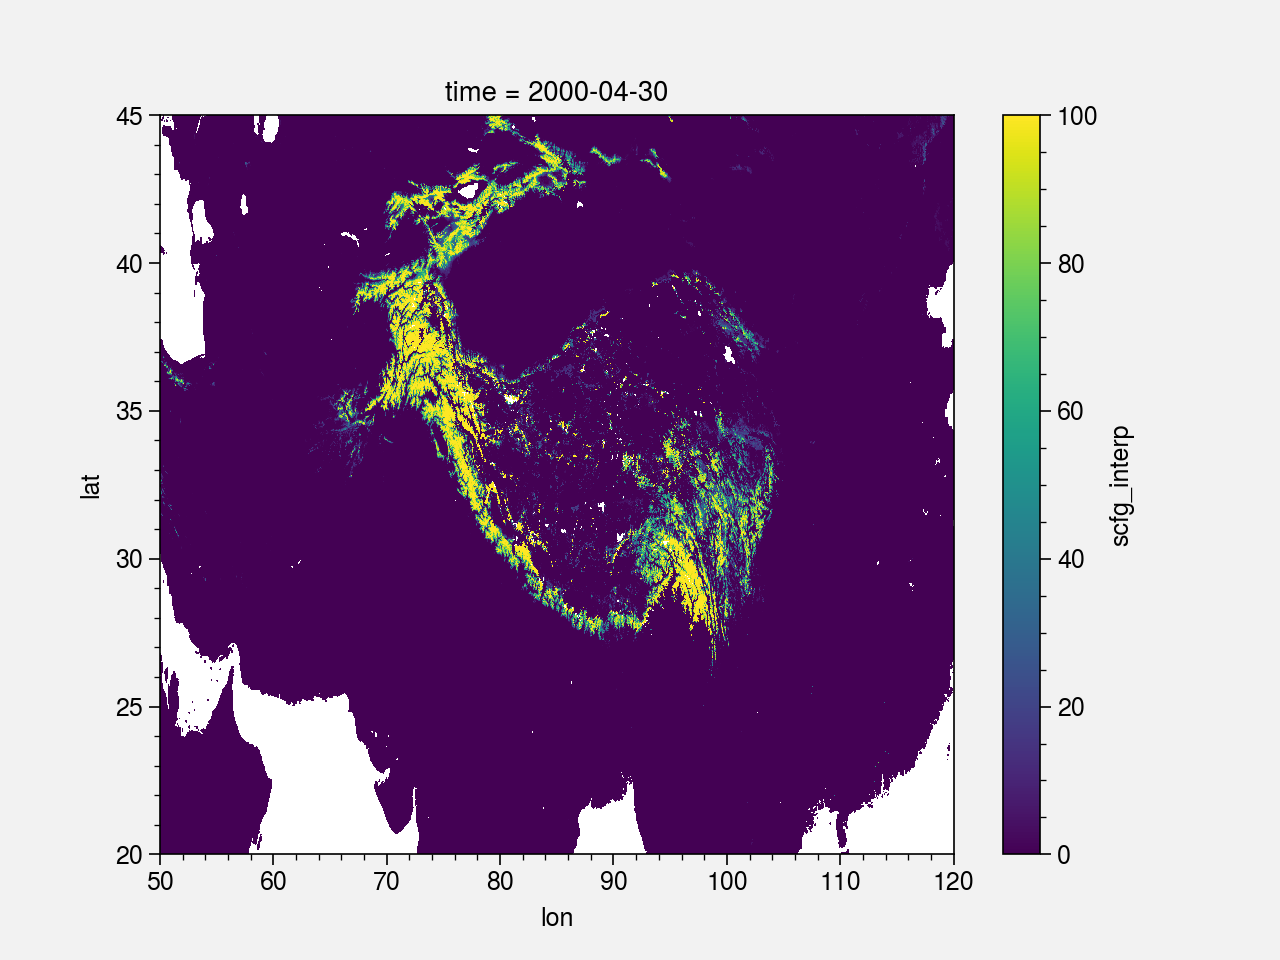

In [32]:
ds.scfg_interp[2].sel(lat=slice(20, 45), lon=slice(50, 120)).plot()

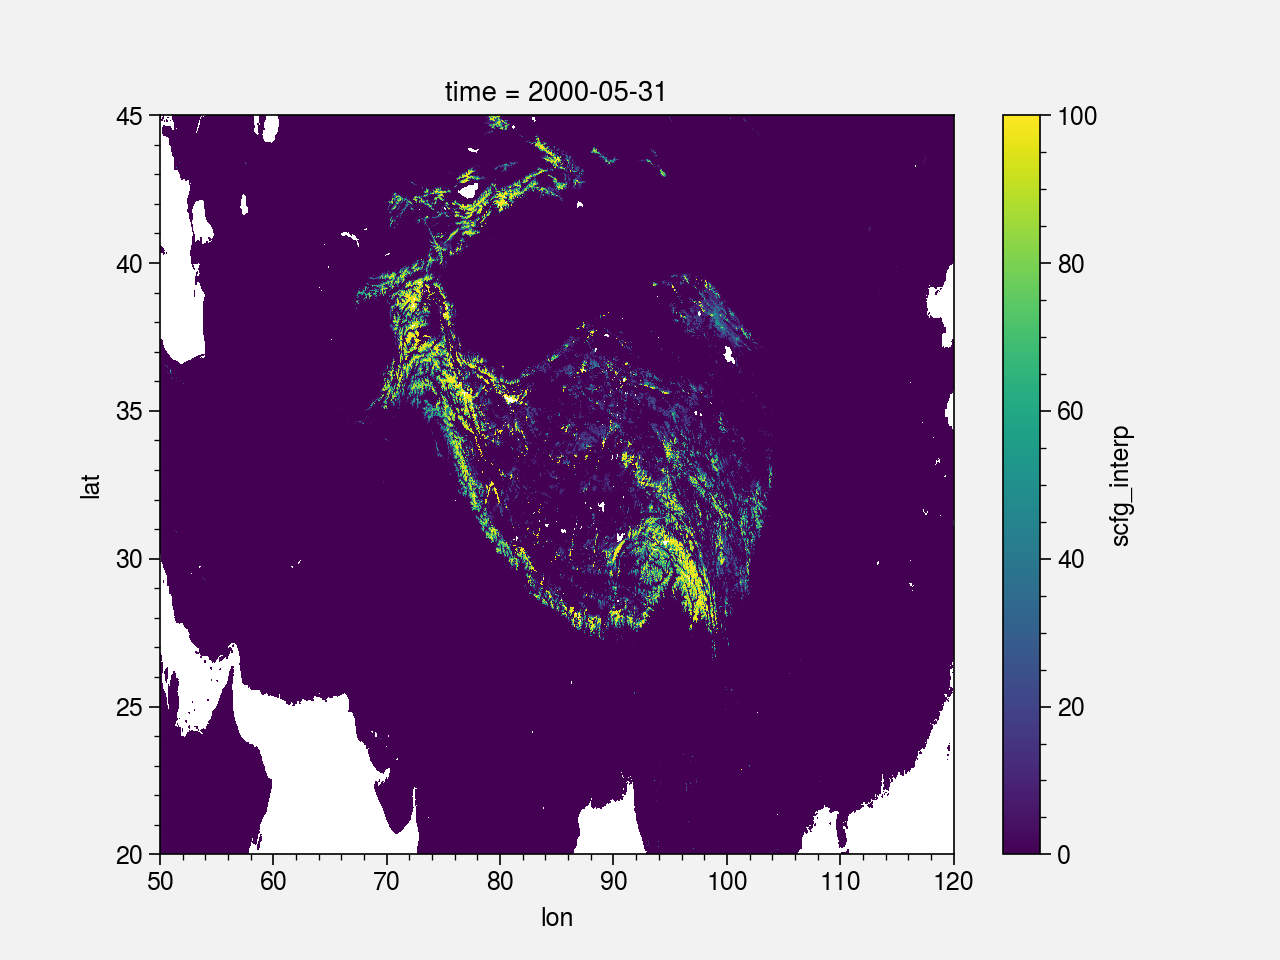

In [33]:
ds.scfg_interp[3].sel(lat=slice(20, 45), lon=slice(50, 120)).plot()

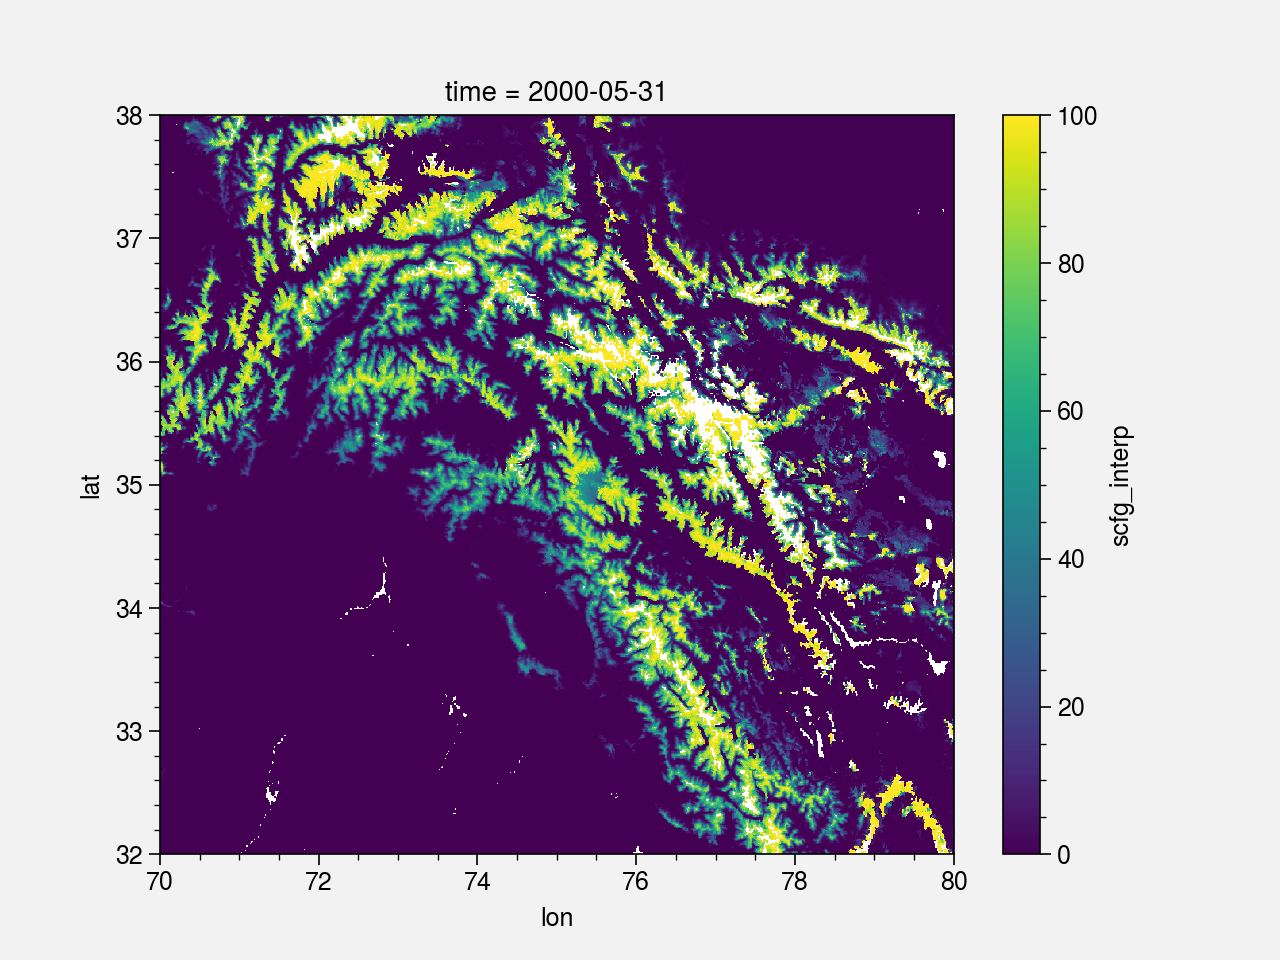

In [36]:
ds.scfg_interp[3].sel(lat=slice(32, 38), lon=slice(70, 80)).plot()

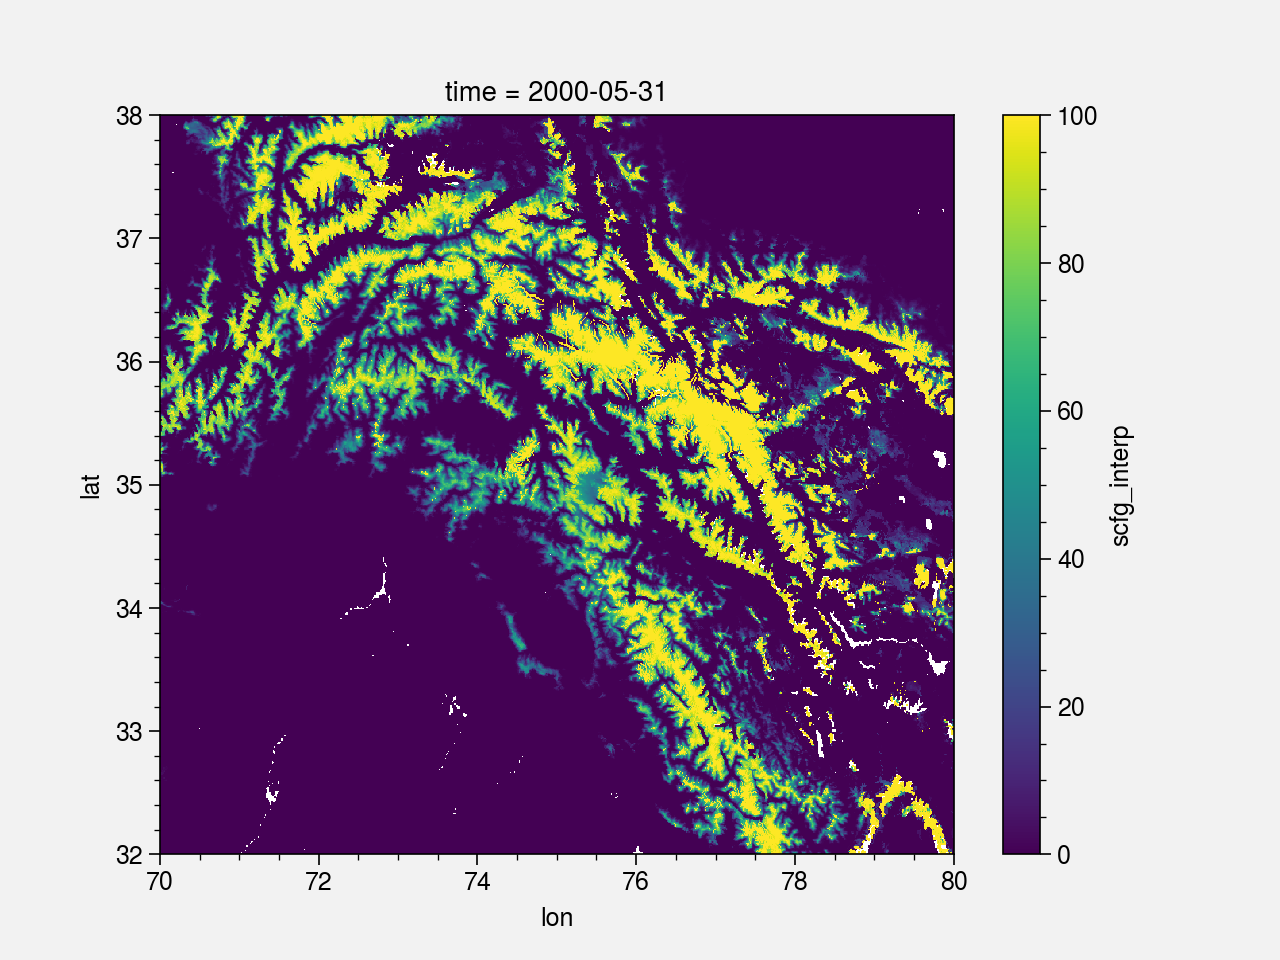

In [37]:
ds.scfg_interp[3].where(ds.mask_ice[3] != 215, 100).sel(lat=slice(32, 38), lon=slice(70, 80)).plot()

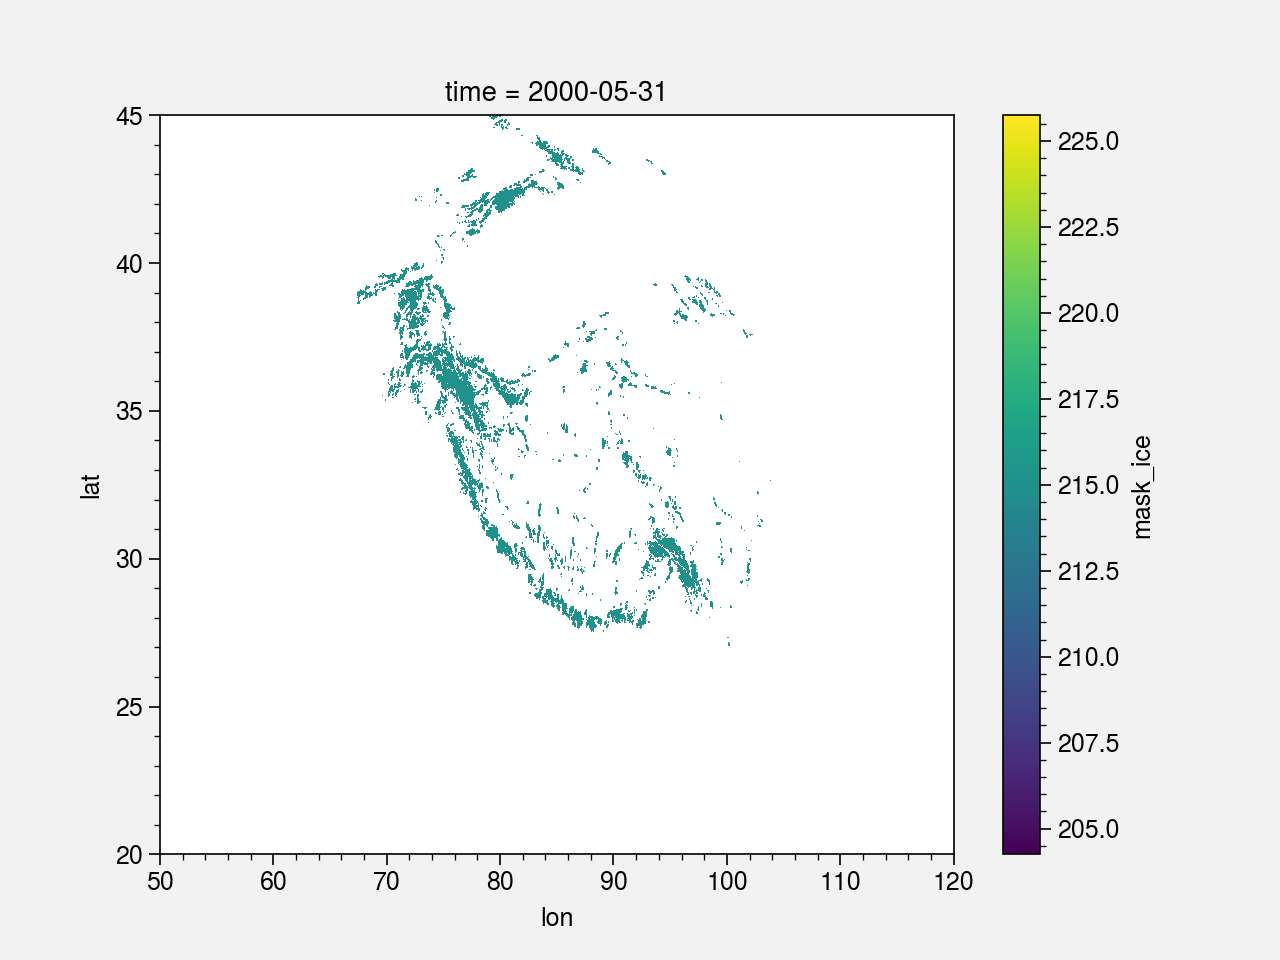

In [34]:
ds.mask_ice[3].sel(lat=slice(20, 45), lon=slice(50, 120)).plot()

In [42]:
%%time

import time

res_orig = 0.01

# for year in [str(y) for y in range(2000, 2021)]:
for year in [str(y) for y in range(2000, 2001)]:
    
    print('\n### '+year)
    
    ds = xr.open_dataset(root_path_out+'/'+year+'-monthly-ESACCI-L3C_SNOW-SCFG-MODIS_TERRA-fv2.0_interp.nc', chunks={'time': 1})
    print('Read files '+root_path_out+'/'+year+'-monthly-ESACCI-L3C_SNOW-SCFG-MODIS_TERRA-fv2.0_interp.nc')
    
    for res in [0.1, 0.25, 0.5, 1]:
        start_time = time.time() # Check time per loop
        print(res)
        n_coarse = int(res/res_orig)
        da_coarse = ds.scfg_interp.coarsen(lat=n_coarse, lon=n_coarse).mean()
        da_coarse.name = 'scfg_interp_'+str(res)+'deg'

        da_coarse_icefilled = ds.scfg_interp.where(ds.mask_ice != 215, 100).coarsen(lat=n_coarse, lon=n_coarse).mean()
        da_coarse_icefilled.name = 'scfg_interp_'+str(res)+'deg_icefilled'

        ds_coarse = da_coarse.to_dataset()
        ds_coarse['scfg_interp_'+str(res)+'deg_icefilled'] = da_coarse_icefilled
        ds_coarse.attrs = ds.attrs

        print(' => Coarsen dataset to '+str(res)+'deg...')

         # Compression
        comp = dict(zlib=True, complevel=4)
        encoding = {var: comp for var in ds_coarse.data_vars}
        ds_coarse.to_netcdf(root_path_out+'_'+str(res)+'deg/'+year+'-monthly-ESACCI-L3C_SNOW-SCFG-MODIS_TERRA-fv2.0_interp_'+str(res)+'deg.nc', encoding=encoding)
        print('Monthly file saved to '+root_path_out+'_'+str(res)+'deg/'+year+'-monthly-ESACCI-L3C_SNOW-SCFG-MODIS_TERRA-fv2.0_interp_'+str(res)+'deg.nc')
        print("--- %s seconds ---" % (time.time() - start_time))


### 2000
Read files /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/scfg/MODIS/v2.0/monthly/2000-monthly-ESACCI-L3C_SNOW-SCFG-MODIS_TERRA-fv2.0_interp.nc
0.1
 => Coarsen dataset to 0.1deg...
Monthly file saved to /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/scfg/MODIS/v2.0/monthly_0.1deg/2000-monthly-ESACCI-L3C_SNOW-SCFG-MODIS_TERRA-fv2.0_interp_0.1deg.nc
--- 49.70319437980652 seconds ---
0.25
 => Coarsen dataset to 0.25deg...
Monthly file saved to /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/scfg/MODIS/v2.0/monthly_0.25deg/2000-monthly-ESACCI-L3C_SNOW-SCFG-MODIS_TERRA-fv2.0_interp_0.25deg.nc
--- 47.65175724029541 seconds ---
0.5
 => Coarsen dataset to 0.5deg...
Monthly file saved to /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/scfg/MODIS/v2.0/monthly_0.5deg/2000-monthly-ESACCI-L3C_SNOW-SCFG-MODIS_TERRA-fv2.0_interp_0.5deg.nc
--- 40.235217332839966 seconds ---
1
 => Coarsen dataset to 1deg...
Monthly file saved to /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/scfg/MODIS/v2.0/monthly_1deg/

## Check

In [35]:
# res = [0.1, 0.25, 0.5, 1]
year = '2000'
res = 0.5
ds = xr.open_dataset(root_path_out+'_'+str(res)+'deg/'+year+'-monthly-ESACCI-L3C_SNOW-SCFG-MODIS_TERRA-fv2.0_interp_'+str(res)+'deg.nc')
ds

<xarray.Dataset>
Dimensions:                       (lat: 360, lon: 720, time: 11)
Coordinates:
  * time                          (time) datetime64[ns] 2000-02-29 ... 2000-1...
  * lat                           (lat) float64 -89.75 -89.25 ... 89.25 89.75
  * lon                           (lon) float64 -179.7 -179.2 ... 179.3 179.8
Data variables:
    scfg_interp_0.5deg            (time, lat, lon) float64 ...
    scfg_interp_0.5deg_icefilled  (time, lat, lon) float64 ...
Attributes:
    processed:                  A linear interpolation on the time dimension ...
    title:                      ESA CCI snow on ground product level L3C dail...
    institution:                ENVEO IT GmbH
    source:                     TERRA MODIS, Collection 6.1: calibrated radia...
    history:                    2021-12-03: ESA snow_cci processing line SCFG...
    references:                 http://snow-cci.enveo.at/
    tracking_id:                071766fd-d627-4051-81c7-4c54e4f4b8f8
    Conventions:                CF-1.9
    product_version:            2.0
    format_version:             CCI Data Standards v2.3, 2021
    summary:                    The SCF product provides daily information on...
    keywords:                   snow cover, MODIS, TERRA
    id:                         20000224-ESACCI-L3C_SNOW-SCFG-MODIS_TERRA-fv2...
    naming_authority:           at.enveo
    keywords_vocabulary:        NASA Global Change Master Directory (GCMD) Sc...
    cdm_data_type:              Swath
    comment:                    The following auxiliary data sets are used fo...
    date_created:               2021-11-18 00:22:17Z
    creator_name:               ENVEO IT GmbH
    creator_url:                http://www.enveo.at/
    creator_email:              snowcci@enveo.at
    project:                    Climate Change Initiative - European Space Ag...
    geospatial_lat_min:         -90
    geospatial_lat_max:         90
    geospatial_lon_min:         -180
    geospatial_lon_max:         180
    geospatial_vertical_min:    0
    geospatial_vertical_max:    0
    geospatial_lon_resolution:  0.01
    geospatial_lat_resolution:  0.01
    geospatial_lat_units:       degrees_north
    geospatial_lon_units:       degrees_east
    time_coverage_start:        20000224T000000Z
    time_coverage_end:          20000224T235959Z
    time_coverage_duration:     P1D
    time_coverage_resolution:   P1D
    standard_name_vocabulary:   CF Standard Name Table v78
    license:                    ESA CCI Data Policy: free and open access
    platform:                   TERRA
    sensor:                     MODIS
    spatial_resolution:         0.01 degree
    key_variables:              scfg
    doi:                        10.5285/8847a05eeda646a29da58b42bdf2a87c

In [36]:
ds.lat

<xarray.DataArray 'lat' (lat: 360)>
array([-89.75, -89.25, -88.75, ...,  88.75,  89.25,  89.75])
Coordinates:
  * lat      (lat) float64 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75

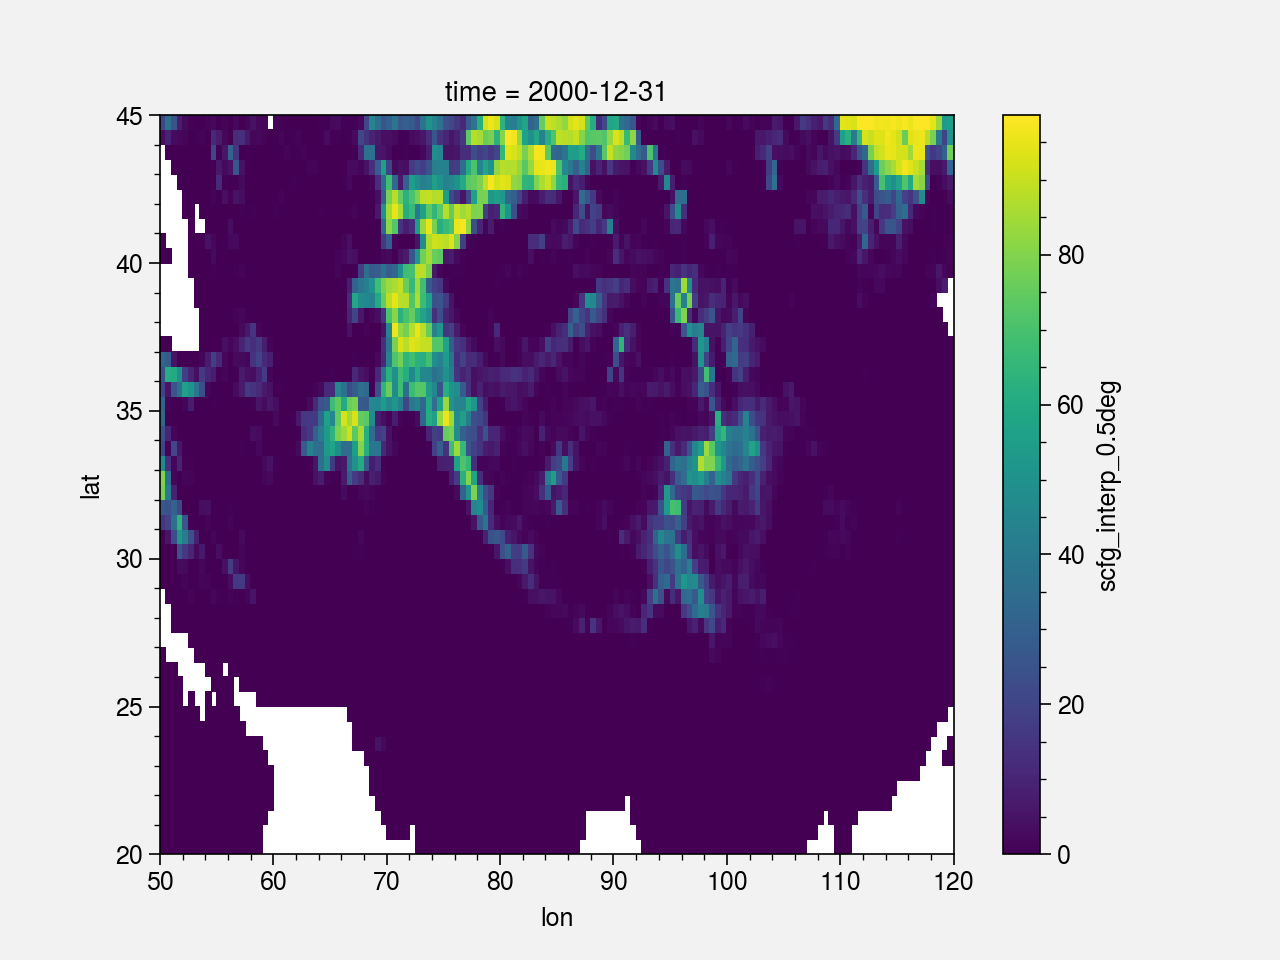

In [37]:
ds['scfg_interp_'+str(res)+'deg'].sel(lat=slice(20, 45), lon=slice(50, 120))[10].plot()

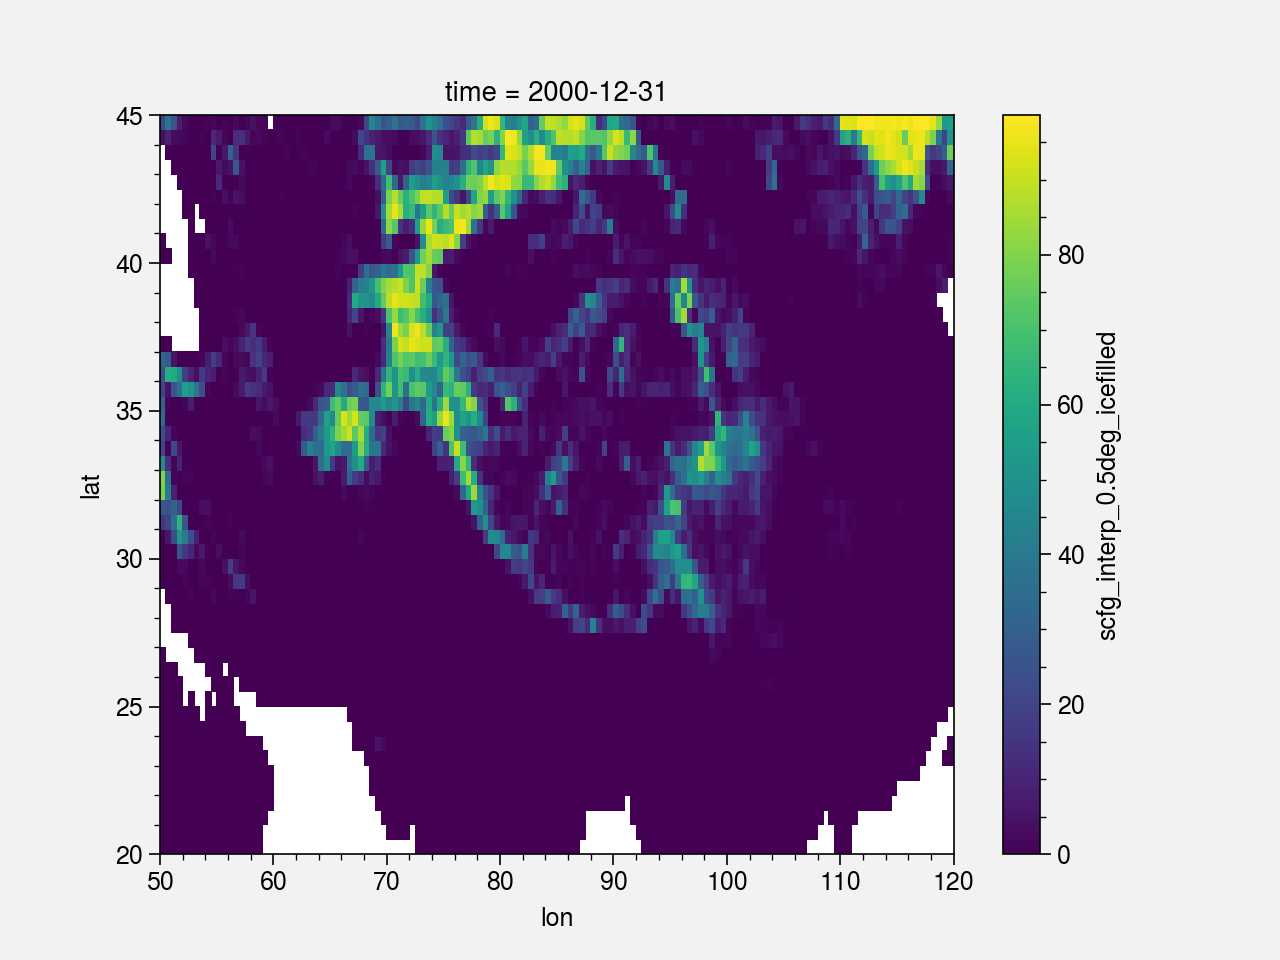

In [38]:
ds['scfg_interp_'+str(res)+'deg_icefilled'].sel(lat=slice(20, 45), lon=slice(50, 120))[10].plot()

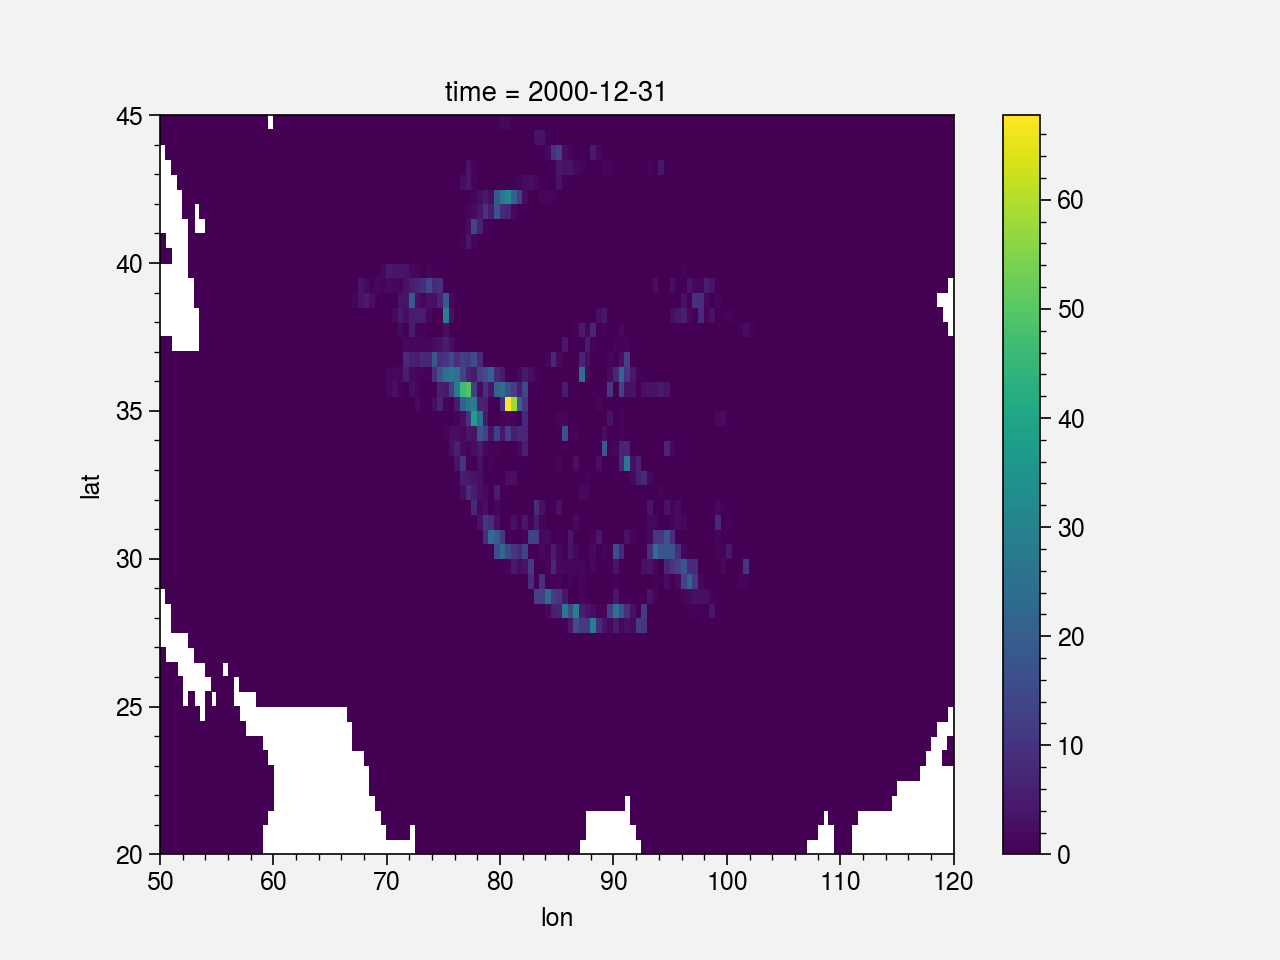

In [39]:
(ds['scfg_interp_'+str(res)+'deg_icefilled']-ds['scfg_interp_'+str(res)+'deg']).sel(lat=slice(20, 45), lon=slice(50, 120))[10].plot()

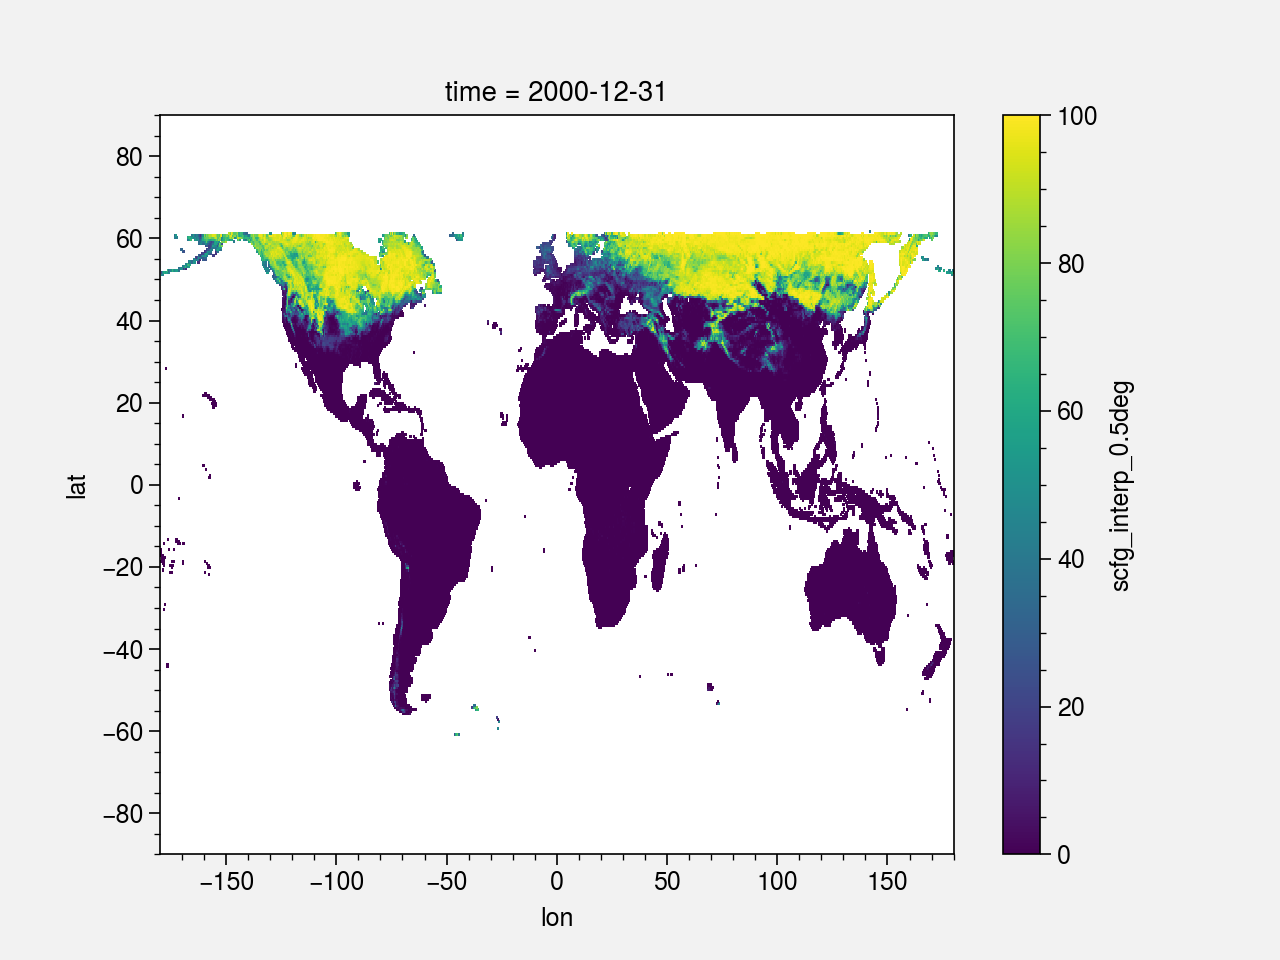

In [40]:
ds['scfg_interp_'+str(res)+'deg'][10].plot()

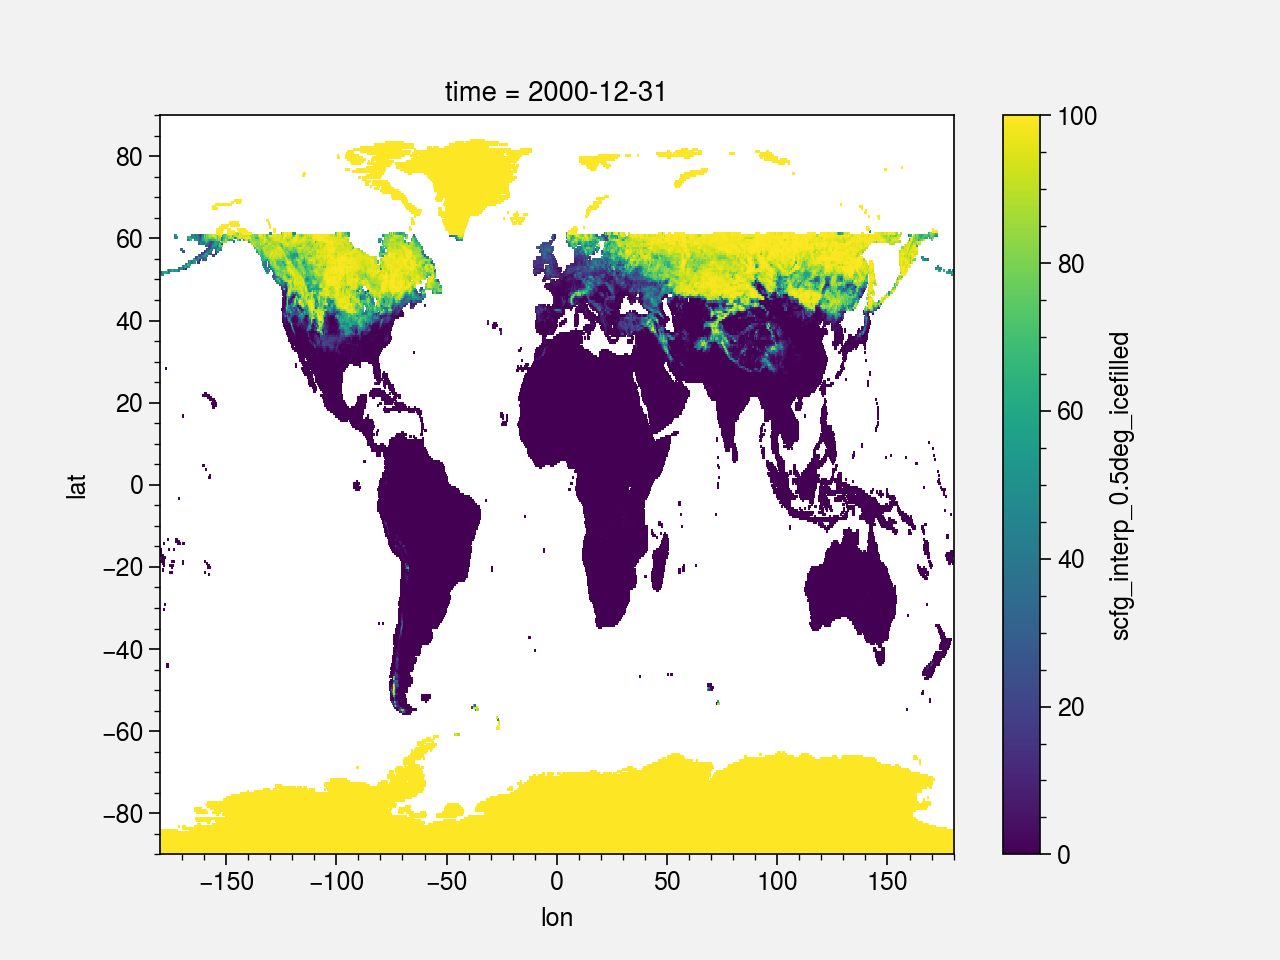

In [41]:
ds['scfg_interp_'+str(res)+'deg_icefilled'][10].plot()